In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
from cost_func import compute_acp_cost,aggregate_air_model,weaning_score_model,compute_acp_cost_model, compute_map_physician_air, is_stable, compute_hr_physician_air, compute_pulsatility_physician_air, unstable_percentage, aggregate_air_physician, weaning_score_physician, super_metric
from reward_func import compute_reward_smooth
from model import WorldModel
from rl_env import AbiomedRLEnvFactory
from cost_func import overall_acp_cost

DATA_PATH = "/abiomed/downsampled/10min_1hr_all_data.pkl"
#this is just for the visualization so it isn't messy
MAX_STEPS_TO_PLOT = 2000

In [2]:
with open(DATA_PATH, 'rb') as f:
    data = pickle.load(f)
episodes = np.concatenate((data['train'],data['val'], data['test']), axis=0)
# episodes = data['train']
print(f"Keys in dataset: {list(data.keys())}")
print(f"Shape of combined set: {len(episodes)}")

Keys in dataset: ['train', 'val', 'test', 'mean', 'std']
Shape of combined set: 17865


In [3]:
#to numpy if tensor
if isinstance(episodes, torch.Tensor):    
    episodes_np = episodes.numpy()  
else:
    episodes_np = np.array(episodes)
actions_all = episodes_np[:, :, -1]

In [4]:



#in order to account for the actions between episodes i am just treating the entire time series like an episode
flattened_actions = actions_all.flatten()
flattened_acp = compute_acp_cost(flattened_actions)

#this is averaged across all actions since the acp function called sums acp per episode
acp_per_timestep = flattened_acp/(len(flattened_actions)-1)
print(f"Mean ACP per timestep accounting for between episodes: {acp_per_timestep:.6f}")


Mean ACP per timestep accounting for between episodes: 0.073368


In [5]:
flattened_actions = episodes_np[:, :, -1].flatten()
#i am just using all of the steps instead of the split up episodes
flattened_map = episodes_np[:, :, 0].flatten()
overall_map_score = compute_map_physician_air(flattened_map, flattened_actions)

print(flattened_map)
if overall_map_score is not None:
    print(f"Overall AIR across all timesteps accounting for between episodes for MAP: {overall_map_score:.6f}")

[95.51750488 97.64806684 99.48813273 ... 55.35730673 58.03034655
 52.48650665]
Overall AIR across all timesteps accounting for between episodes for MAP: 0.075566


In [6]:
flattened_actions = episodes_np[:, :, -1].flatten()
flattened_hr = episodes_np[:, :, 9].flatten()
overall_hr_score = compute_hr_physician_air(flattened_hr, flattened_actions)
if overall_hr_score is not None:
    print(f"Overall AIR across all timesteps accounting for between episodes for HR: {overall_hr_score:.6f}")

Overall AIR across all timesteps accounting for between episodes for HR: 0.043157


In [7]:
flattened_actions = episodes_np[:, :, -1].flatten()
flattened_pulsatility = episodes_np[:, :, 7].flatten()
overall_pulsatility_score = compute_pulsatility_physician_air(flattened_pulsatility, flattened_actions)
if overall_pulsatility_score is not None:
    print(f"Overall AIR across all timesteps accounting for between episodes for pulsatility: {overall_pulsatility_score:.6f}")

Overall AIR across all timesteps accounting for between episodes for pulsatility: 0.061362


In [8]:
states_all = episodes_np[:, :, :-1]
flattened_states = states_all.reshape(-1, states_all.shape[-1])
unstable_percentage = unstable_percentage(flattened_states)
print(f"Percentage of unstable states: {unstable_percentage}")

Percentage of unstable states: 17.822558074447244


In [9]:
overall_weaning_score = weaning_score_physician(flattened_states, flattened_actions)
print(f"Overall weaning score {overall_weaning_score}")

Overall weaning score -0.024611756001038224


In [10]:
total_air = aggregate_air_physician(flattened_states, flattened_actions)
print(f"Aggregate AIR: {total_air}")

Aggregate AIR: 0.030380987382089917


In [11]:
print(flattened_states[0])
super_acp = super_metric(flattened_states, flattened_actions)
acp_timestep = super_acp/(len(flattened_actions)-1)
print(f"Super Metric ACP: {super_acp}")
print(f"Super Metric ACP per timestep: {acp_timestep}")

[9.55175049e+01 3.89947638e+03 2.37867920e+02 3.83526803e+01
 1.39765734e+01 1.16824373e+02 8.12071603e+01 3.56172133e+01
 5.34618863e+02 6.60000000e+01 7.08239484e-01 6.19862945e+01]
Super Metric ACP: 6809.057172816964
Super Metric ACP per timestep: 0.03176177318122094


In [12]:
#look at the next cell for reward
all_steps_np = np.concatenate(episodes_np, axis=0)

In [14]:
episodes_np.shape

(17865, 12, 13)

In [12]:

total_steps_available = all_steps_np.shape[0]
print(f"Total timesteps: {total_steps_available}")

# Group the data in bins with 24 steps
episode_length = 24
num_bins = total_steps_available // episode_length
#creates bins and fits the samples into 3D
binned_steps = all_steps_np[:num_bins * episode_length].reshape(num_bins, episode_length, -1)
print(f"Created {num_bins} bins with {episode_length} steps")
# Randomly select 100 of these bins
num_episodes_to_sample = 633
#no replacement
sampled_bin_indices = np.random.choice(num_bins, num_episodes_to_sample, replace=False)

all_episode_rewards = []

# Loop through the 100 randomly selected bins
for bin_idx in sampled_bin_indices:
    # Get one bin
    episode_bin = binned_steps[bin_idx]
    
    normalized_rewards_for_episode = []
    # Loop through each of the 24 steps in the bin
    for step_data in episode_bin:
        step_tensor = torch.tensor(step_data, dtype=torch.float32)
        raw_reward = compute_reward_smooth(step_tensor.unsqueeze(0))
        
        # Apply normalizatio
        norm_reward = (raw_reward + 4) / 5
        clipped_reward = np.clip(norm_reward, -1.0, 1.0)
        normalized_rewards_for_episode.append(clipped_reward)
    
    # Find the total reward for this simulated episode
    total_episode_reward = sum(normalized_rewards_for_episode)
    all_episode_rewards.append(total_episode_reward)

mean_total_episode_reward = np.mean(all_episode_rewards)

print(f"Mean total normalized reward per episode from all bins: {mean_total_episode_reward:.6f}")


Total timesteps: 214380
Created 8932 bins with 24 steps


Mean total normalized reward per episode from all bins: -13.496964


In [22]:
# EPISODE_LENGTH_STEPS = 36
# num_episodes = len(all_steps_np) // EPISODE_LENGTH_STEPS
# episodes_6hr = all_steps_np[:num_episodes * EPISODE_LENGTH_STEPS].reshape(
#     num_episodes, EPISODE_LENGTH_STEPS, -1
# )

episodes_np_res = episodes_np.reshape(-1,6,13)
num_to_evaluate = episodes_np_res.shape[0] #episodes_np_res.shape[0]
if len(episodes_np_res) < num_to_evaluate:
    num_to_evaluate = len(episodes_np_res)

#

In [23]:
episodes_to_evaluate = episodes_np_res[::2]

In [24]:
episodes_to_evaluate.shape

(12051, 6, 13)

In [4]:
def plot_policy(state, action, title, legend=None):
    """

    Plot the policy for the given state and environment.
    Args: 
        eval_env: The evaluation environment.
        state ([max_steps, forecast_horizon*num_features]): The predicted state to plot. Includes the first p-level.
        all_states ([max_steps+1, forecast_horizon*num_features]): The real states including the first inputted state.
        writer: The writer to log the plot.
    """

    input_color = 'tab:blue'
    pred_color = 'tab:red' #label="input",
    gt_color = 'tab:red'
    rl_color = 'tab:blue'

    hr_color = 'tab:orange'
    pulsat_color = 'tab:green'

    max_steps = 6
    forecast_n = 6
    action_unnorm  = action

    
    state_unnorm = state.reshape(max_steps+1, forecast_n, -1)
    first_action = state_unnorm[0,:,-1]
    first_action = np.array(np.bincount(np.rint(np.array(first_action)).astype(int)).argmax()).reshape(-1)
    action = np.concatenate([first_action, np.asarray(action, dtype=float)])
    action = np.repeat(action,forecast_n)

    fig, ax1 = plt.subplots(figsize=(6, 4), dpi=300,  layout='constrained')  # Smaller plot size
                                    
    default_x_ticks = range(0, 181, 18)
    x_ticks = np.array(list(range(0, 31, 3)))
    plt.xticks(default_x_ticks, x_ticks)
    x1 = len(state_unnorm[0, :, 0].reshape(-1,1))
    x2 = len(state_unnorm[1:, :, 0].reshape(-1,1))
    ax1.axvline(x=x1, linestyle='--', c='black', alpha =0.7)


    
    line_obs, = ax1.plot(range(0, x1+x2), state_unnorm[:, :, 0].reshape(-1,1),  '--', label ='Observed MAP', alpha=0.5,  color=gt_color, linewidth=2.0)
    line_obs2, = ax1.plot(range(0, x1+x2), state_unnorm[:, :, 9].reshape(-1,1),  '--', label ='Observed HR', alpha=0.5,  color=hr_color, linewidth=2.0)
    line_obs3, = ax1.plot(range(0, x1+x2), state_unnorm[:, :, 7].reshape(-1,1),  '--', label ='Observed PULSAT', alpha=0.5,  color=pulsat_color, linewidth=2.0)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    line_pl2, = ax2.plot(range(0, x1+x2), action.reshape(-1,1),label ='Input PLL', color=rl_color, linewidth=2.0)

    # Combined legend for all lines
    lines = [line_obs,line_obs2, line_obs3, line_pl2]
    labels = ['Observed MAP', 'Observed HR', 'Observed PULSAT', 'Input PL']
    if legend:
        ax1.legend(lines, labels, loc='upper right', bbox_to_anchor=(0.99, 0.99), fancybox=True, ncol=1, fontsize='medium')  # Legend at the bottom
    ax1.set_ylabel('MAP (mmHg)', size="large", color='tab:red')
    ax1.tick_params(axis='y', colors='tab:red')
    ax1.set_xlabel('Time (hour)', size="x-large")
    ax1.set_title(f"{title}", size="x-large", fontweight="bold")
    # ax2.set_ylabel('P-level', size="x-large", color='tab:blue', labelpad=10)
    ax2.tick_params(axis='y', colors='tab:blue')
    ax2.set_ylim(2, 10)
    ax1.set_ylim(10, 130)

   
    # ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.grid()
    # ax1.spines['left'].set_visible(False)
    # fig.subplots_adjust(left=0.14, right=0.88, top=0.90, bottom=0.24)
    plt.show()

# Data-based

In [5]:

sliced_data = episodes_np[::4]
print(sliced_data.shape)
sliced_states  = sliced_data[:,:6, :]
print(sliced_states.shape)
sliced_next_states = sliced_data[:, 6:, :]

#reshape into N/6, 6, 6, 13
sliced_state_episodic = sliced_states[:-3].reshape(-1, 6, 6, 13)
print(sliced_state_episodic.shape)
sliced_next_state_episodic = sliced_next_states[:-3].reshape(-1, 6, 6, 13)
print(sliced_next_state_episodic.shape)
sliced_data_episodic = sliced_data[:-3].reshape(-1, 6, 12, 13)

(4467, 12, 13)
(4467, 6, 13)
(744, 6, 6, 13)
(744, 6, 6, 13)


In [6]:
eval_episodes = sliced_state_episodic.shape[0]
episode_len = sliced_state_episodic.shape[1]

In [7]:
eval_episodes,episode_len

(744, 6)

In [8]:
col = [0,1,2,3,4,5,6,7,8,9,10,12]

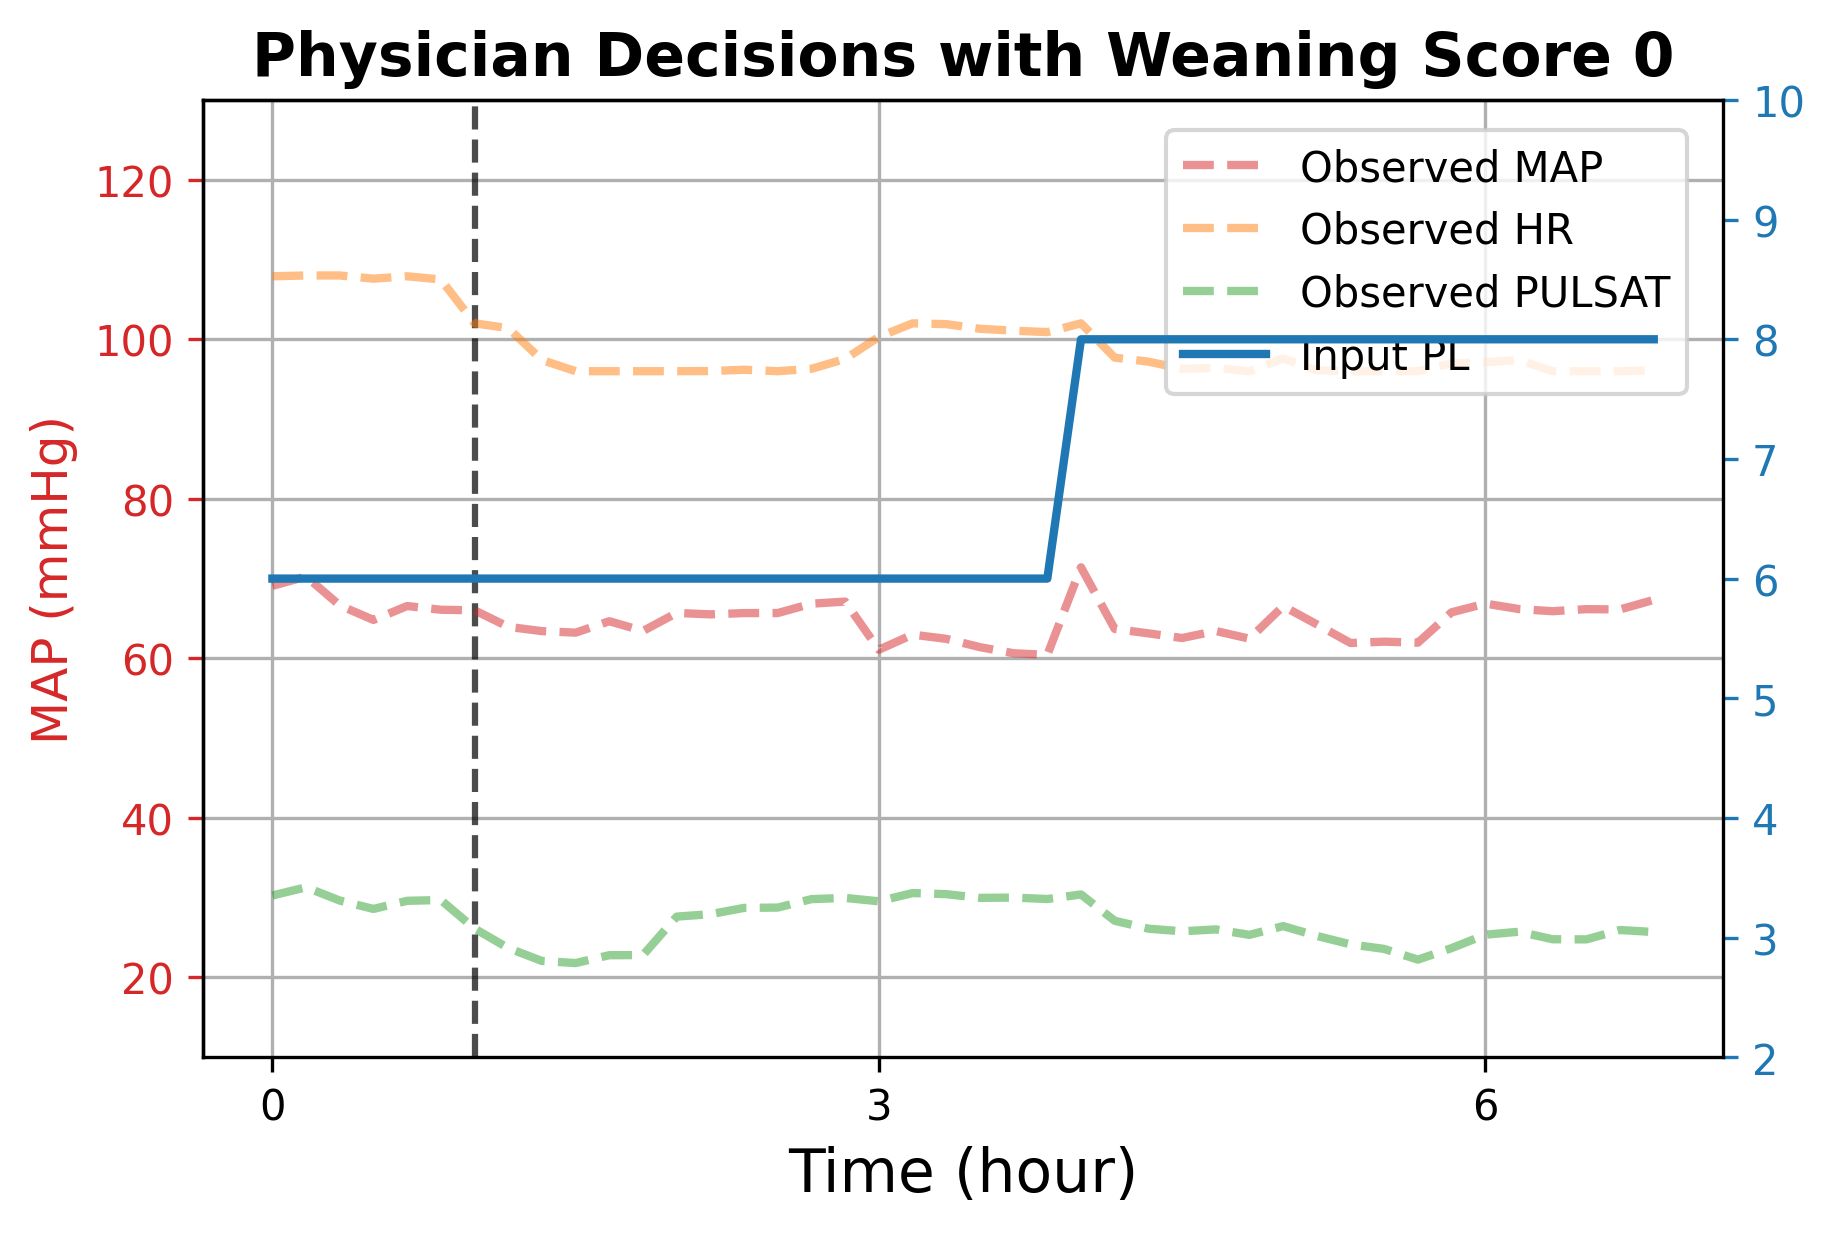

Weaning score in this episode -0.16666666666666666


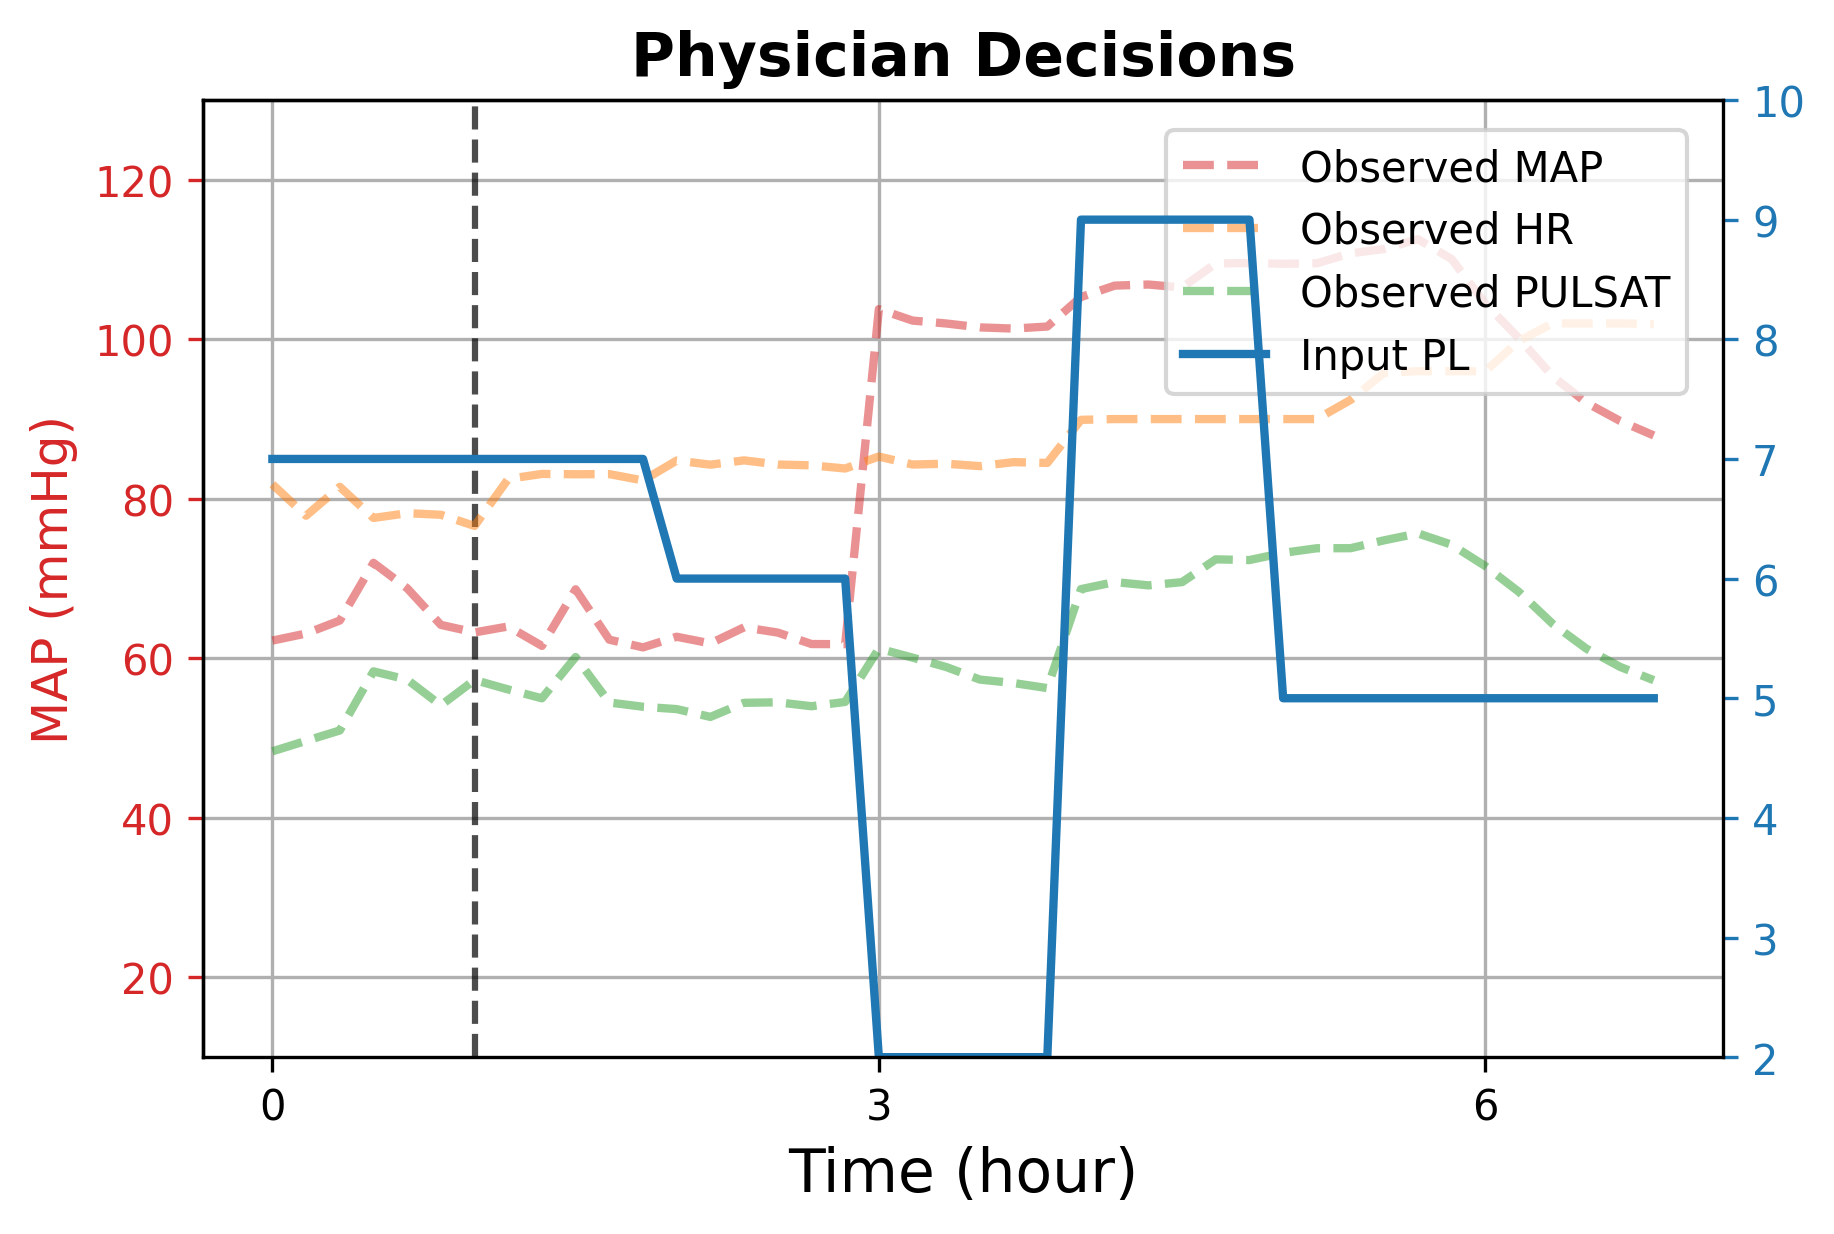

ACP in this episode 15.0


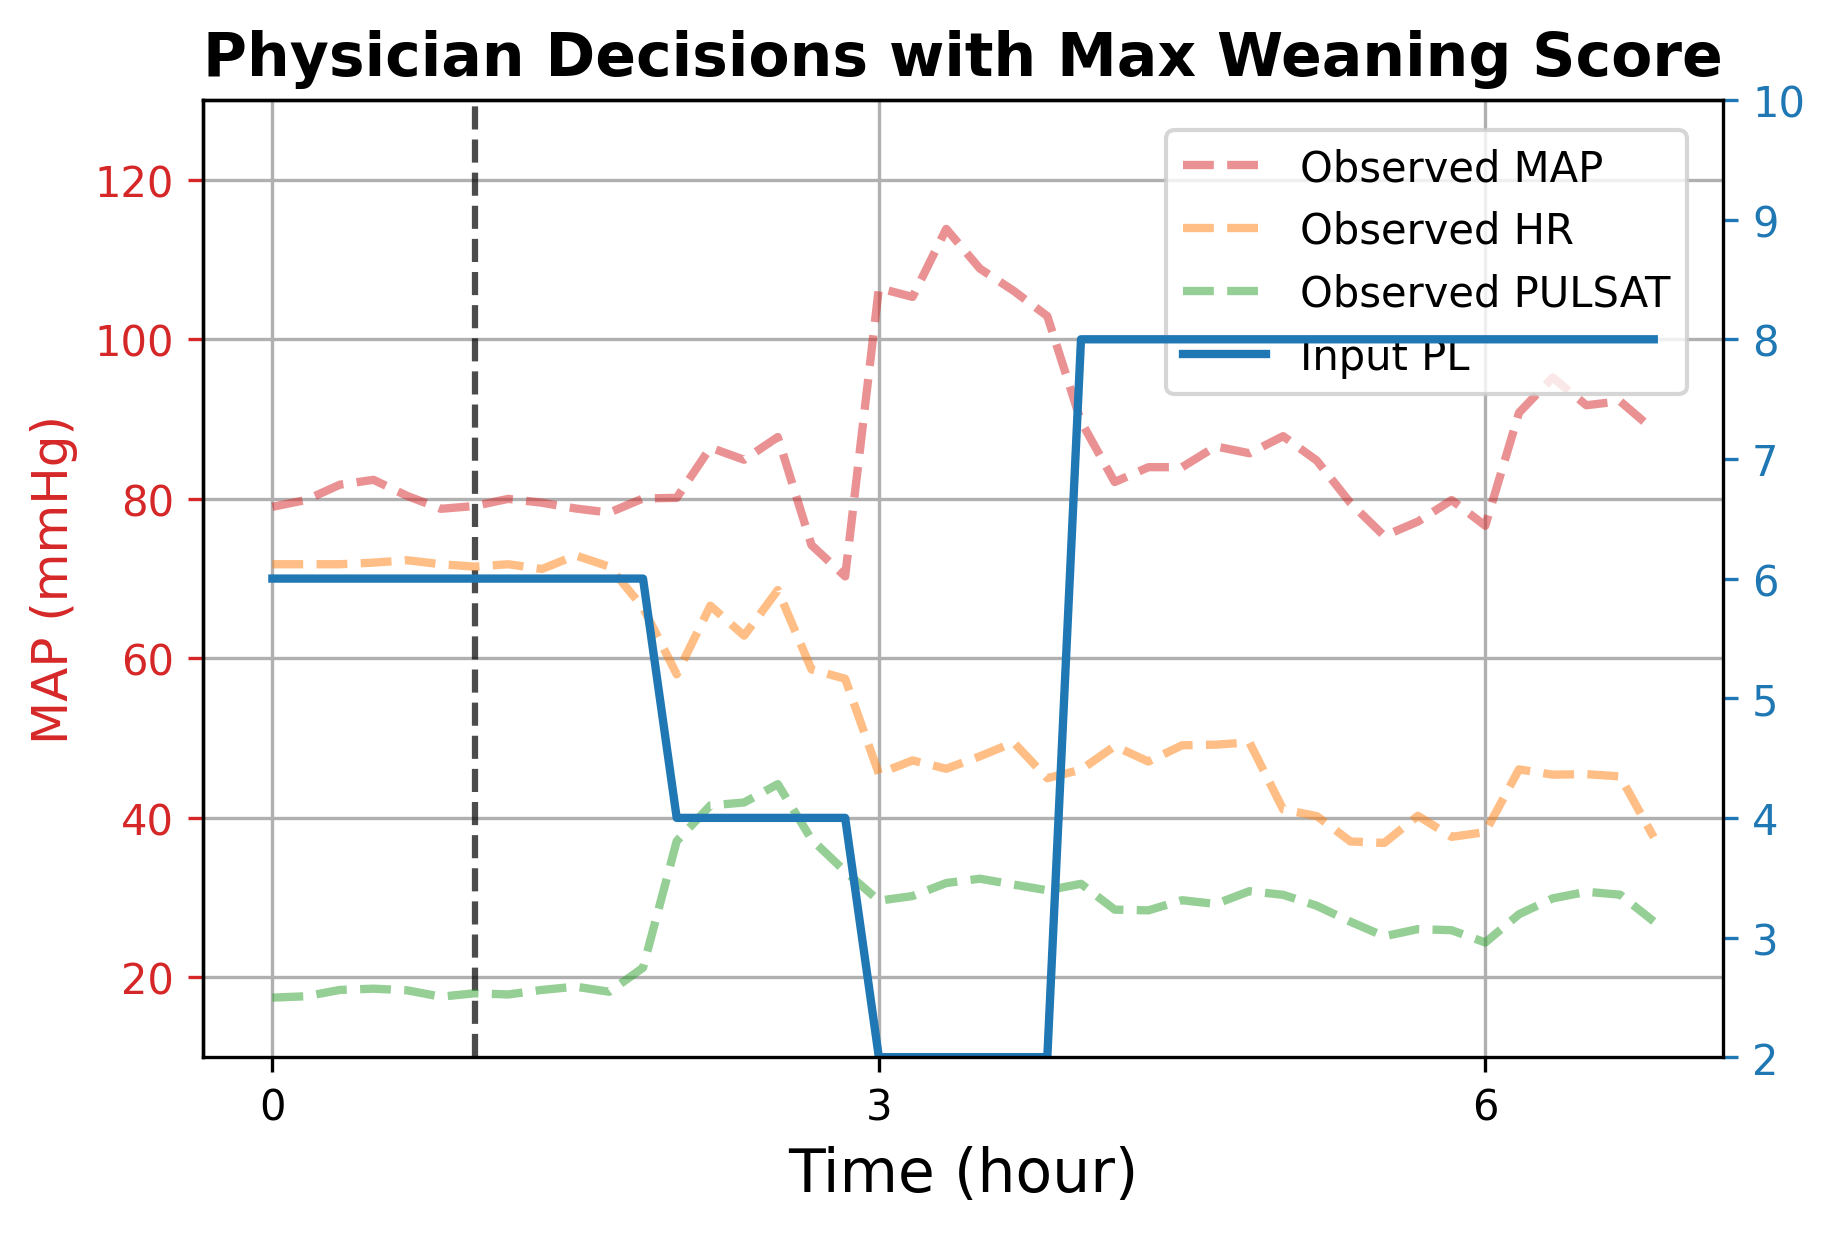

Weaning score in this episode 2.0


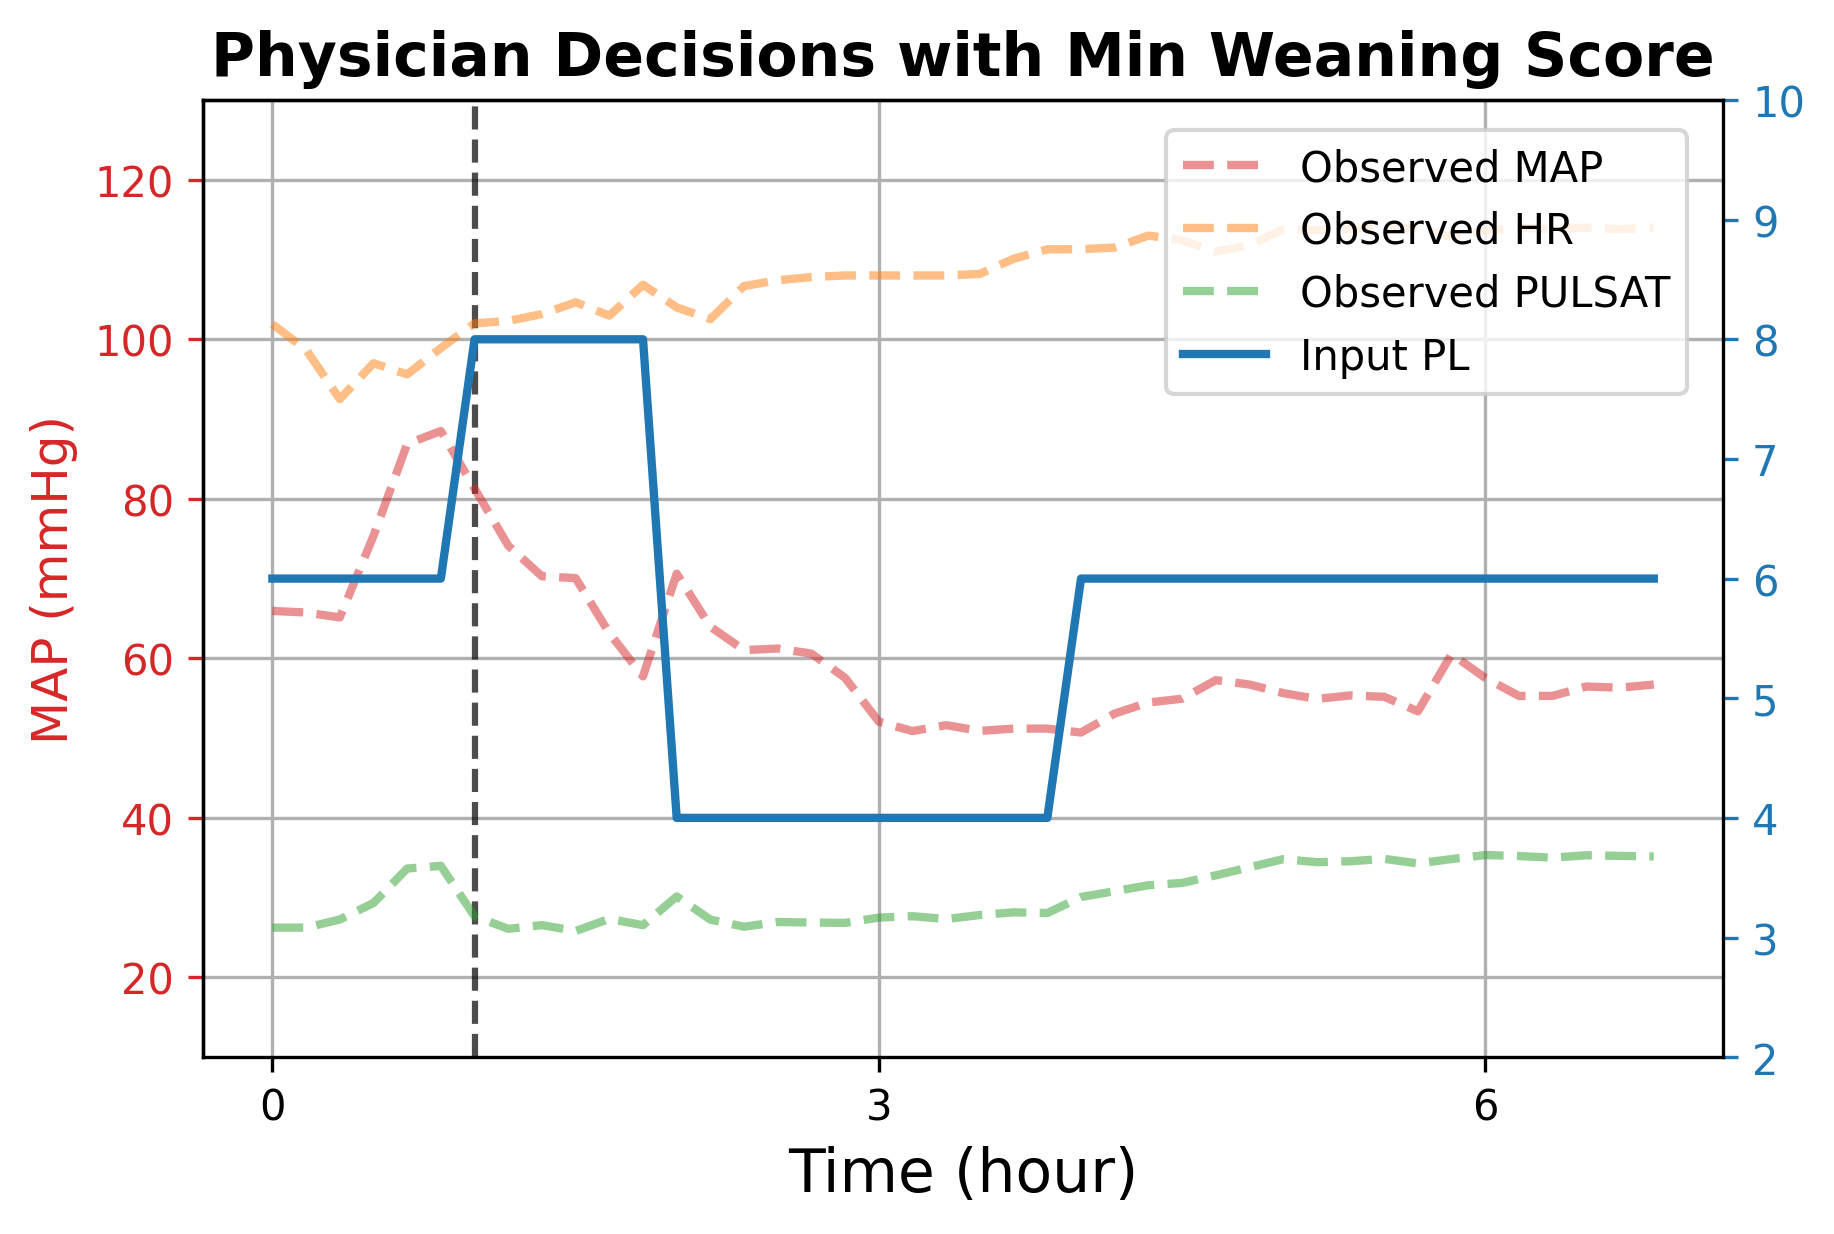

Weaning score in this episode -1.0


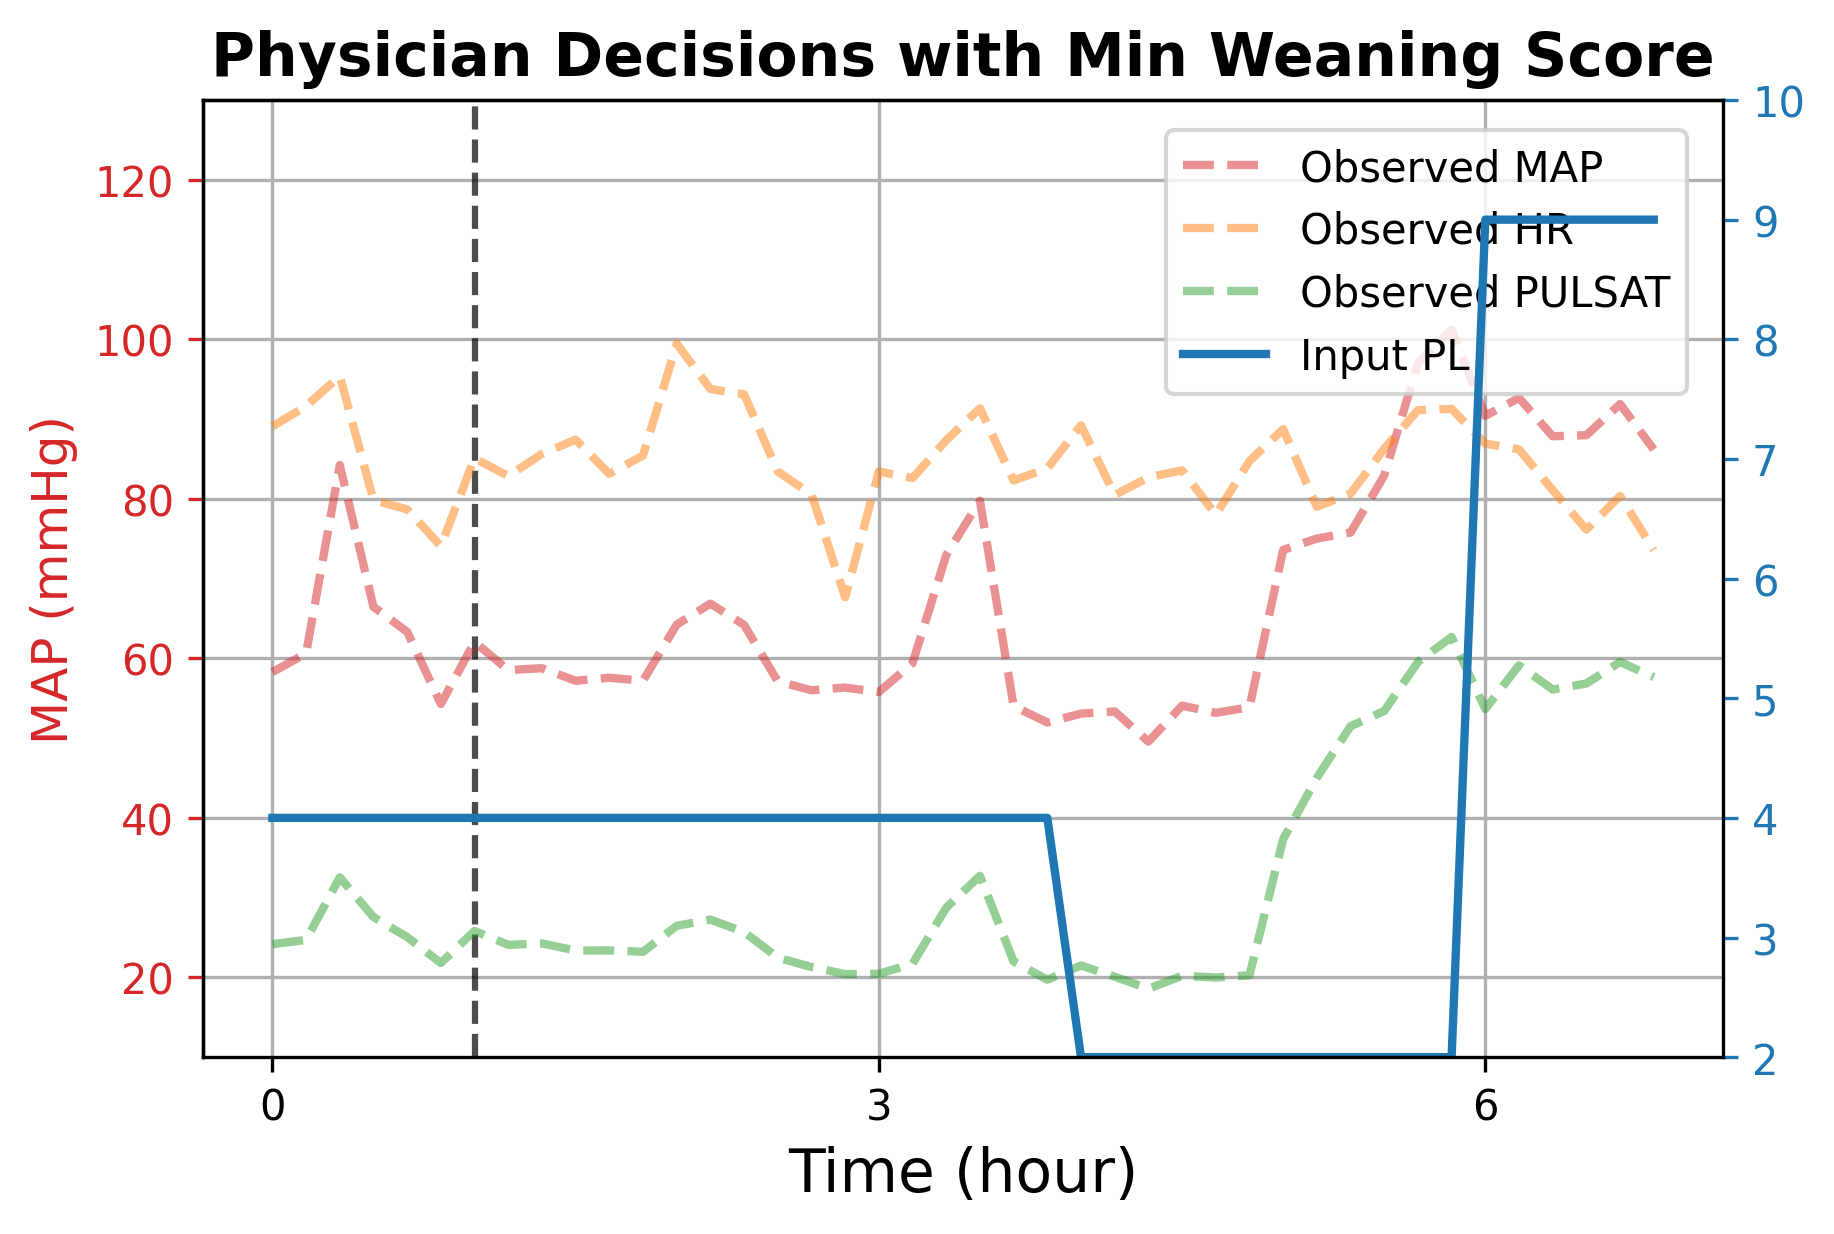

Weaning score in this episode -1.0


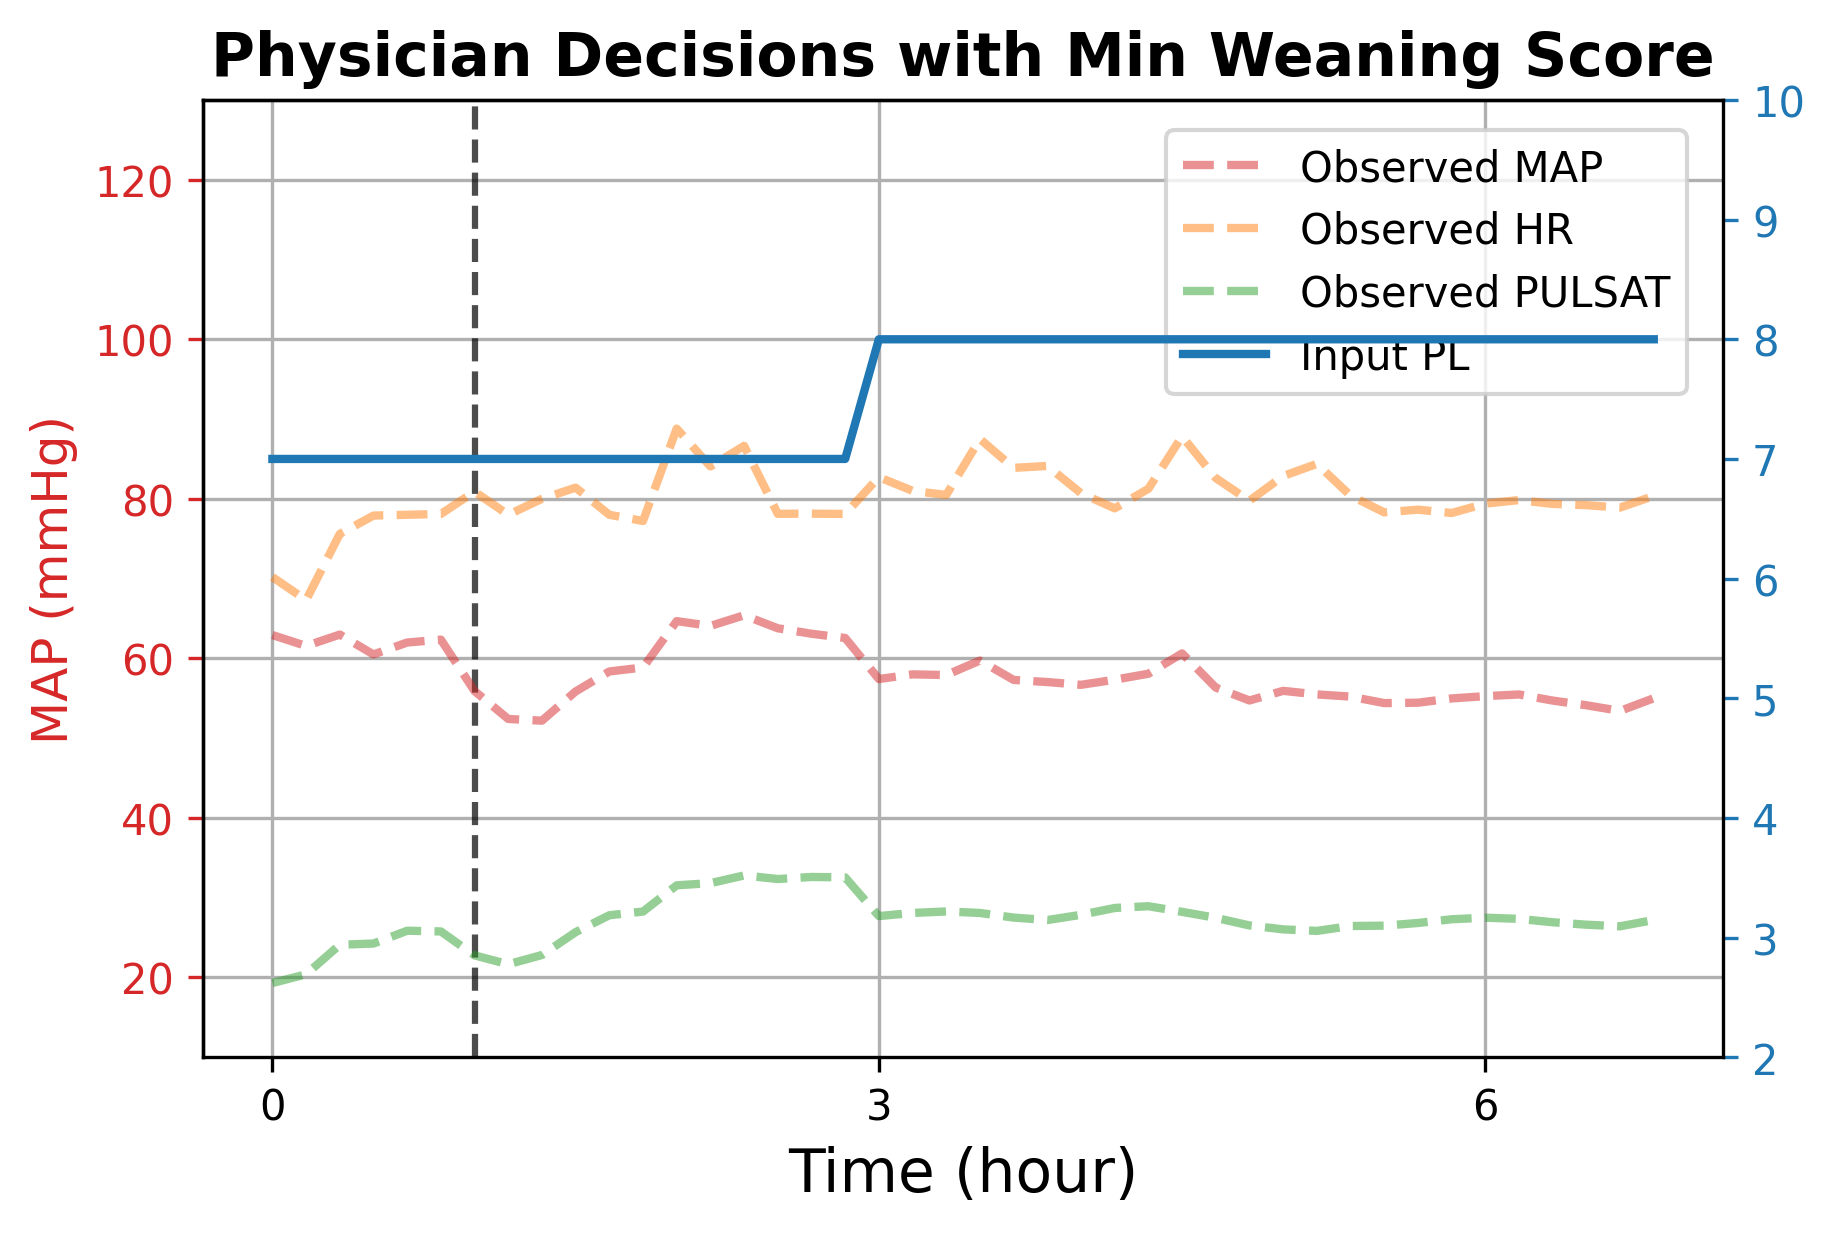

Weaning score in this episode -1.0


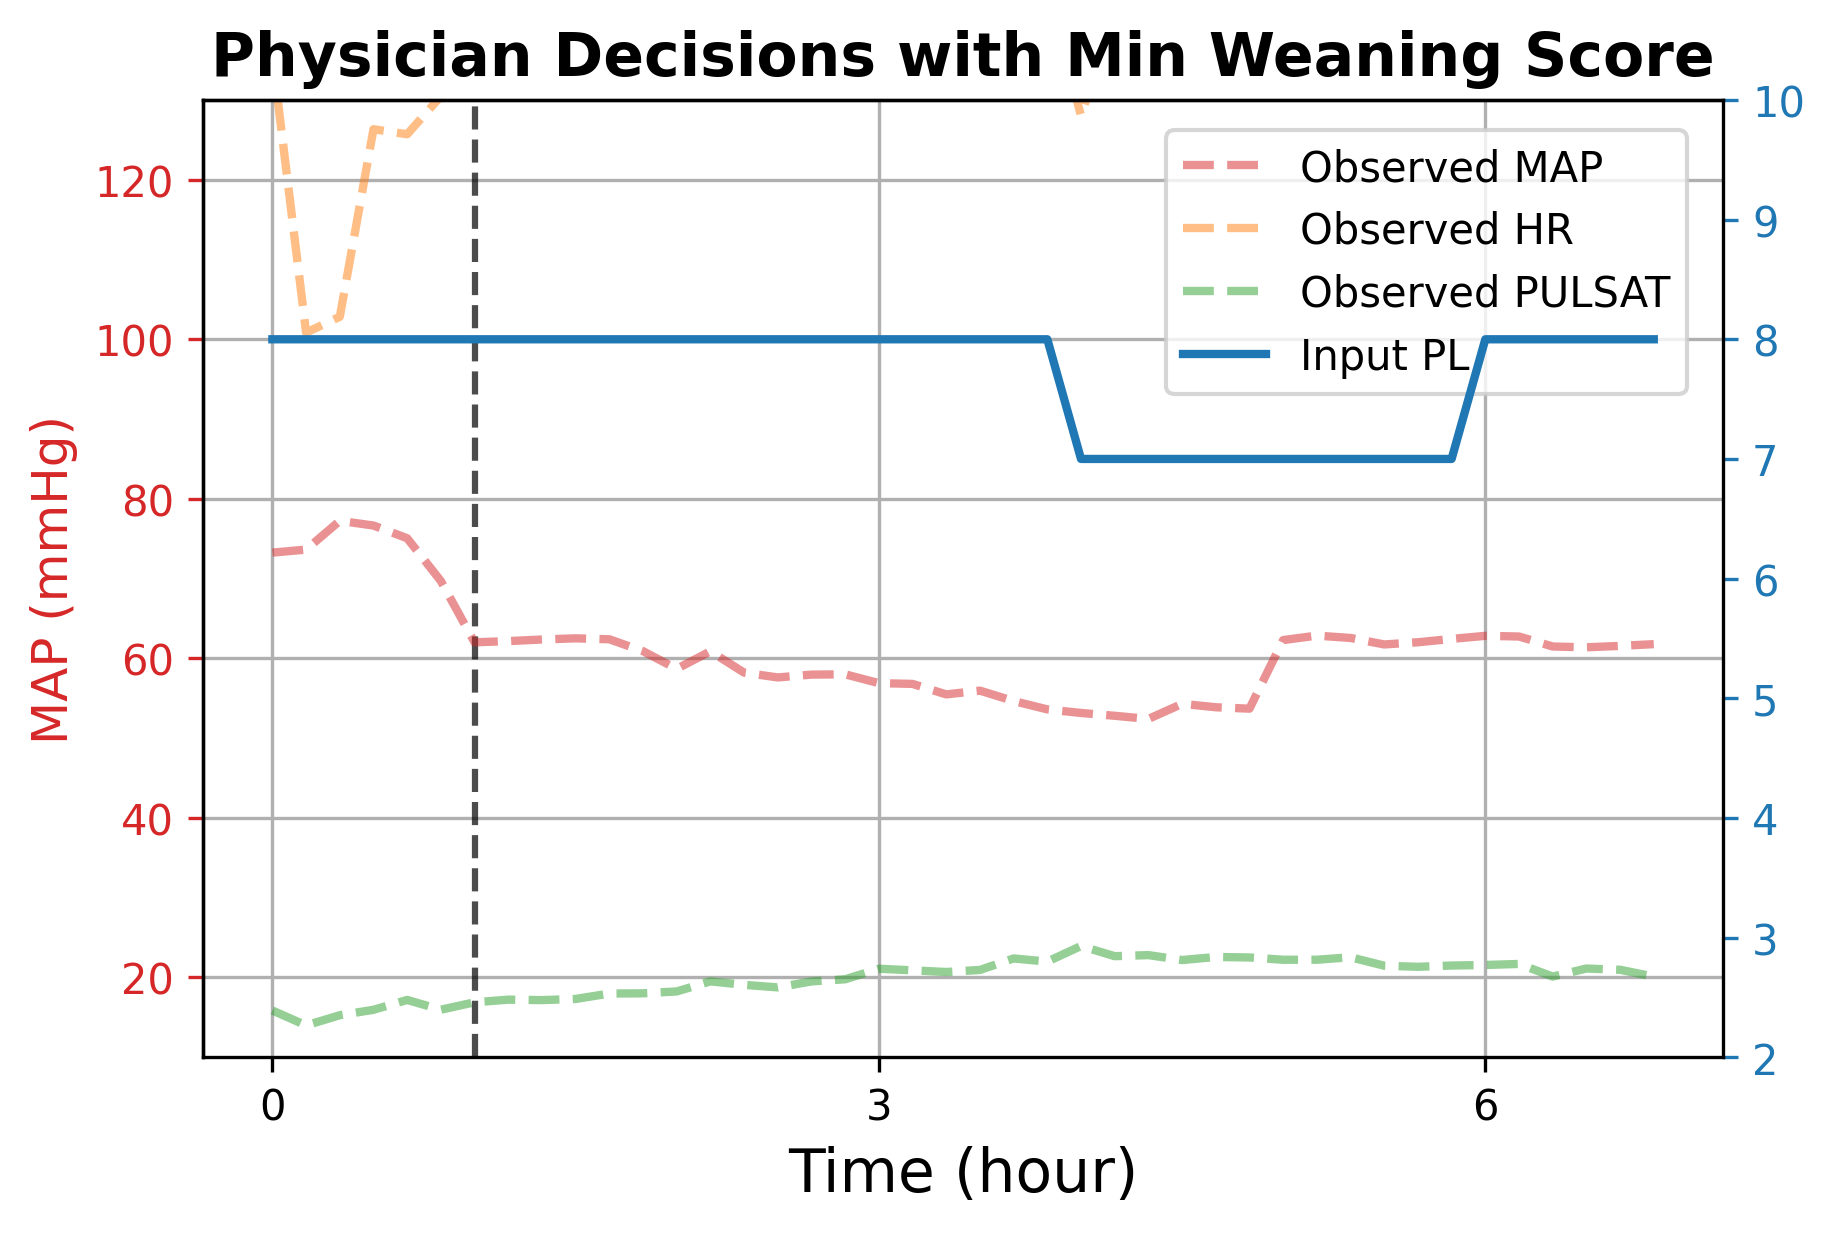

Weaning score in this episode -1.0


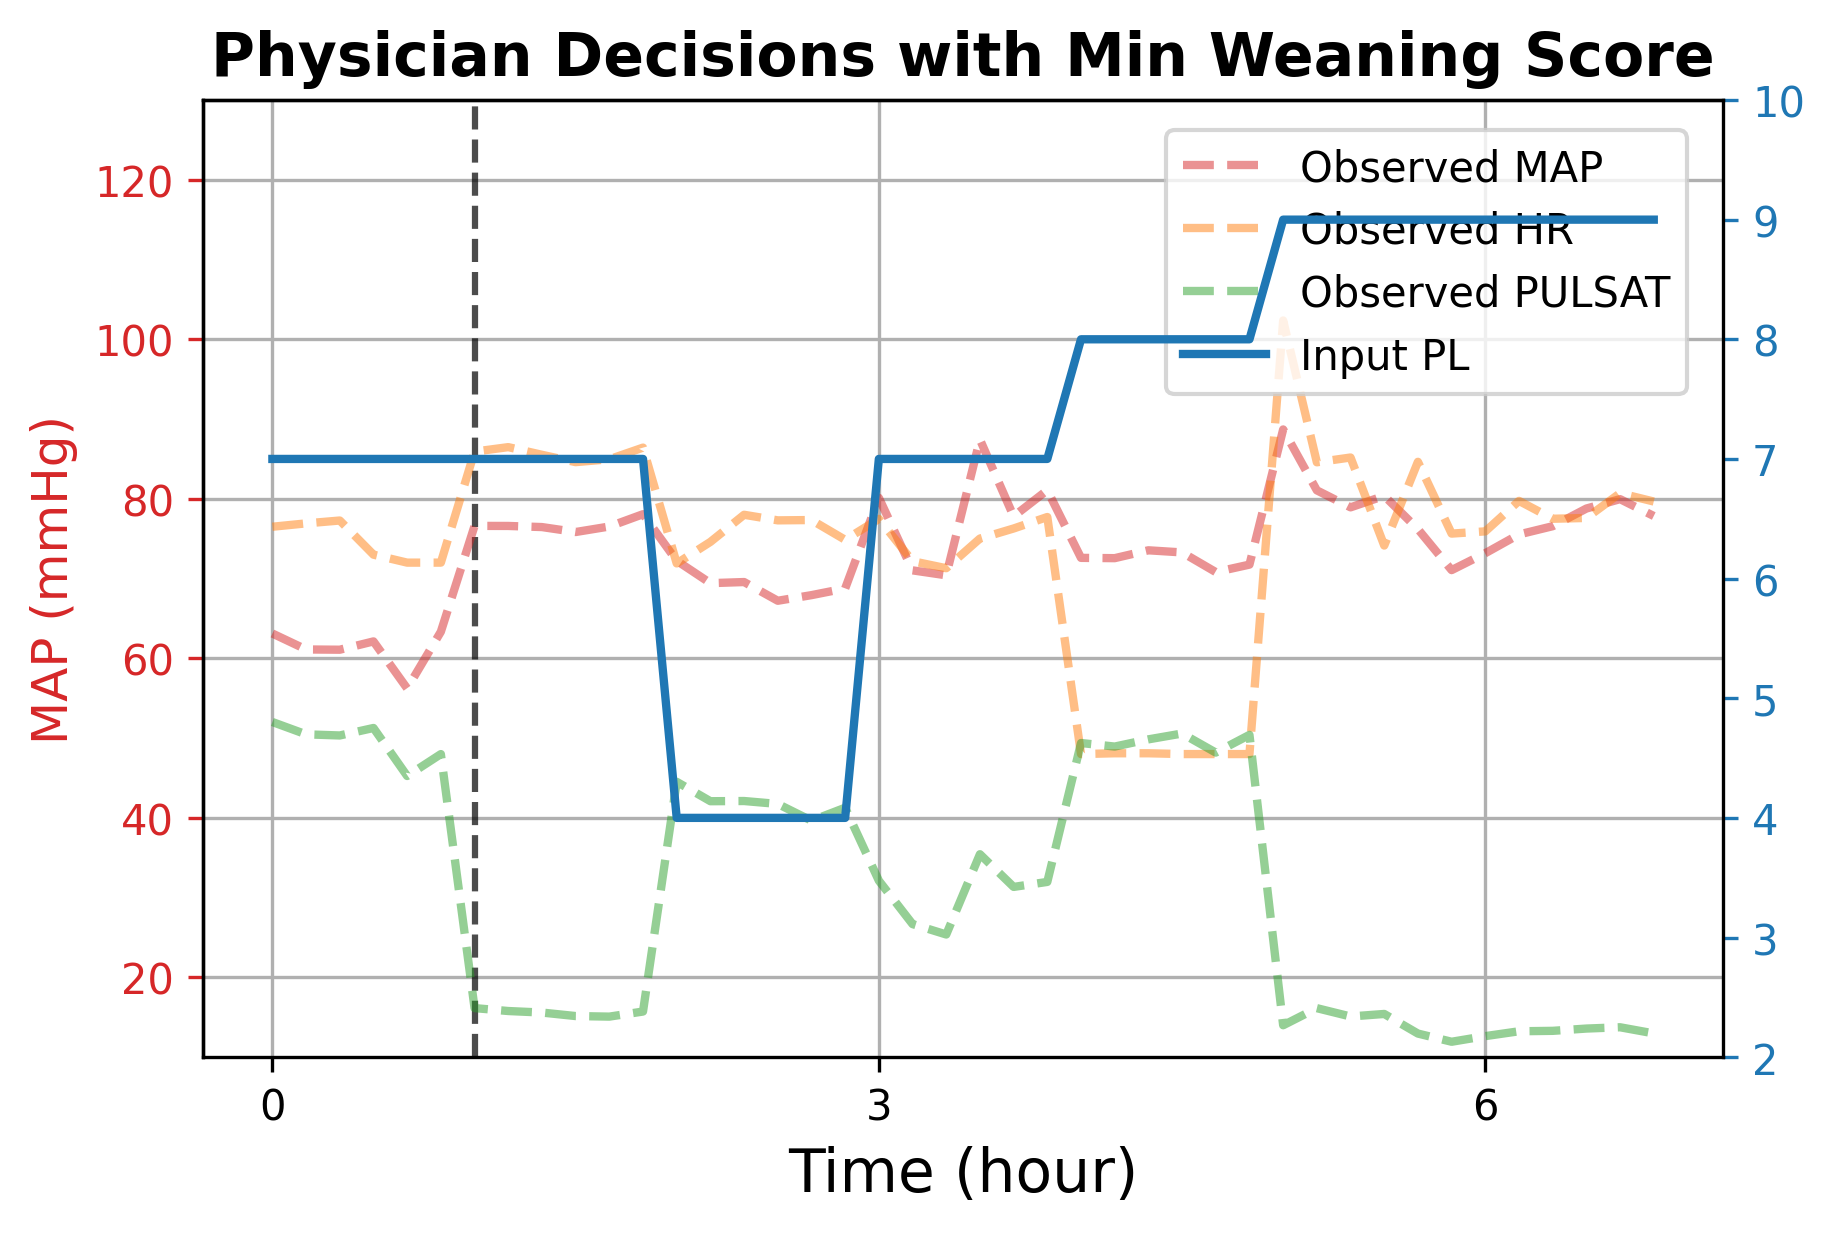

Weaning score in this episode -1.0


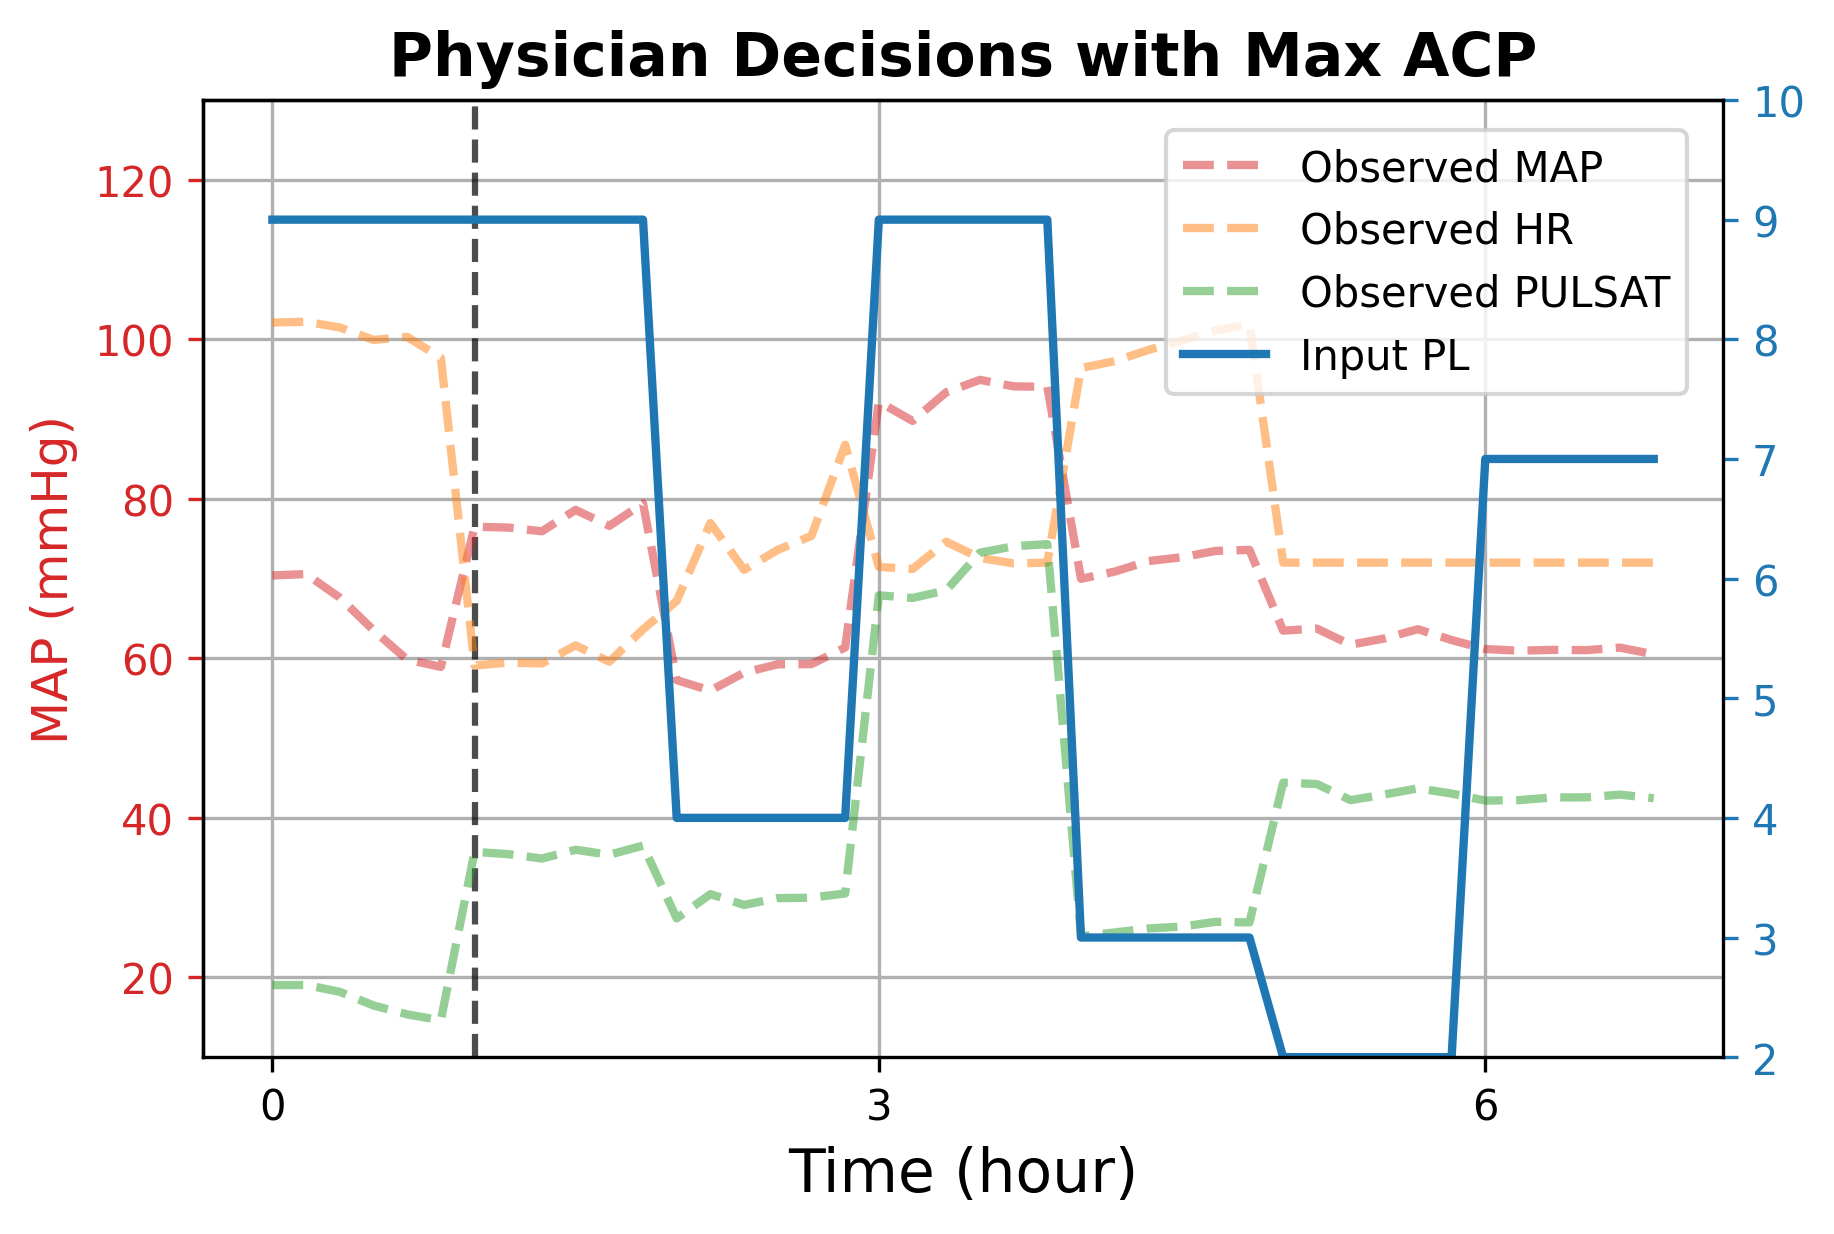

ACP in this episode 21.0


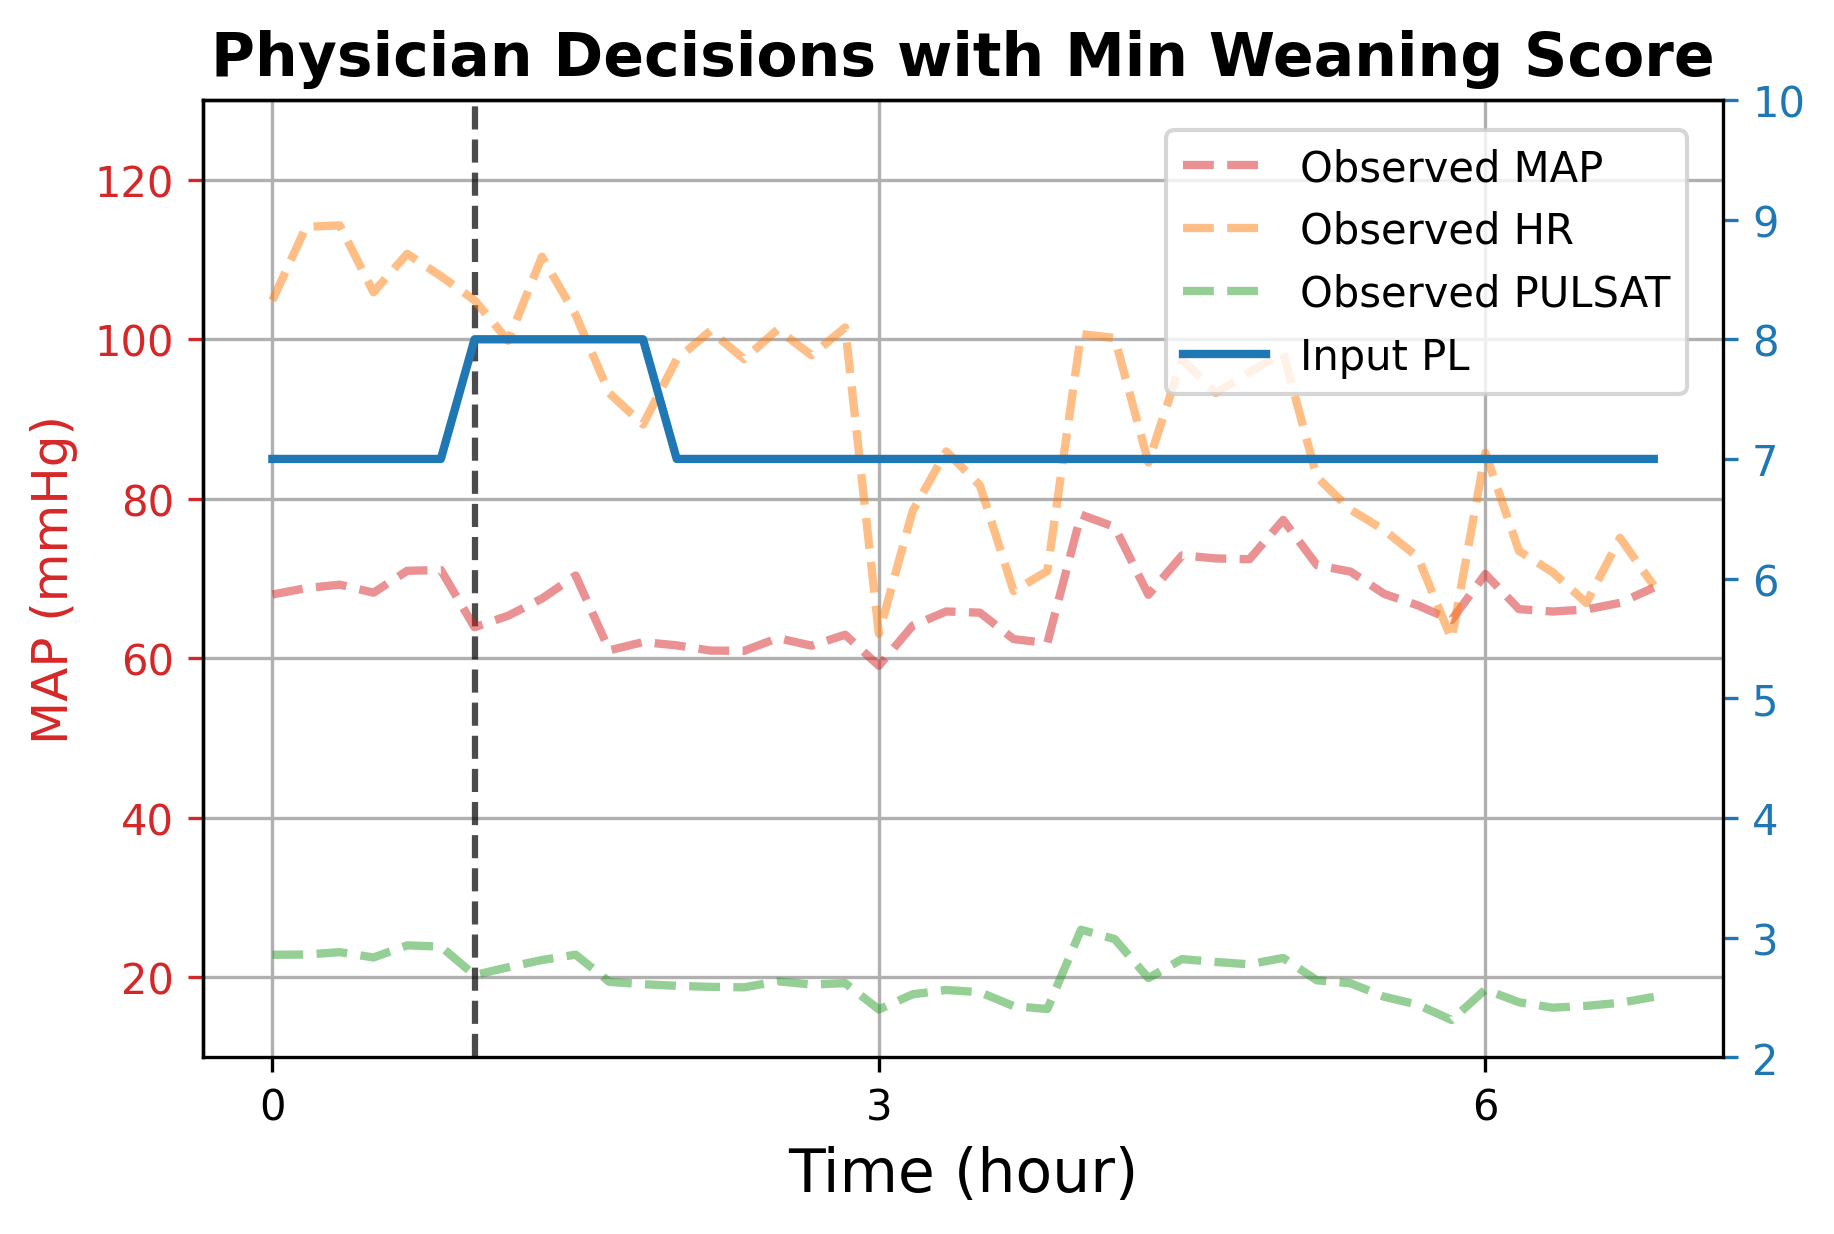

Weaning score in this episode -1.0


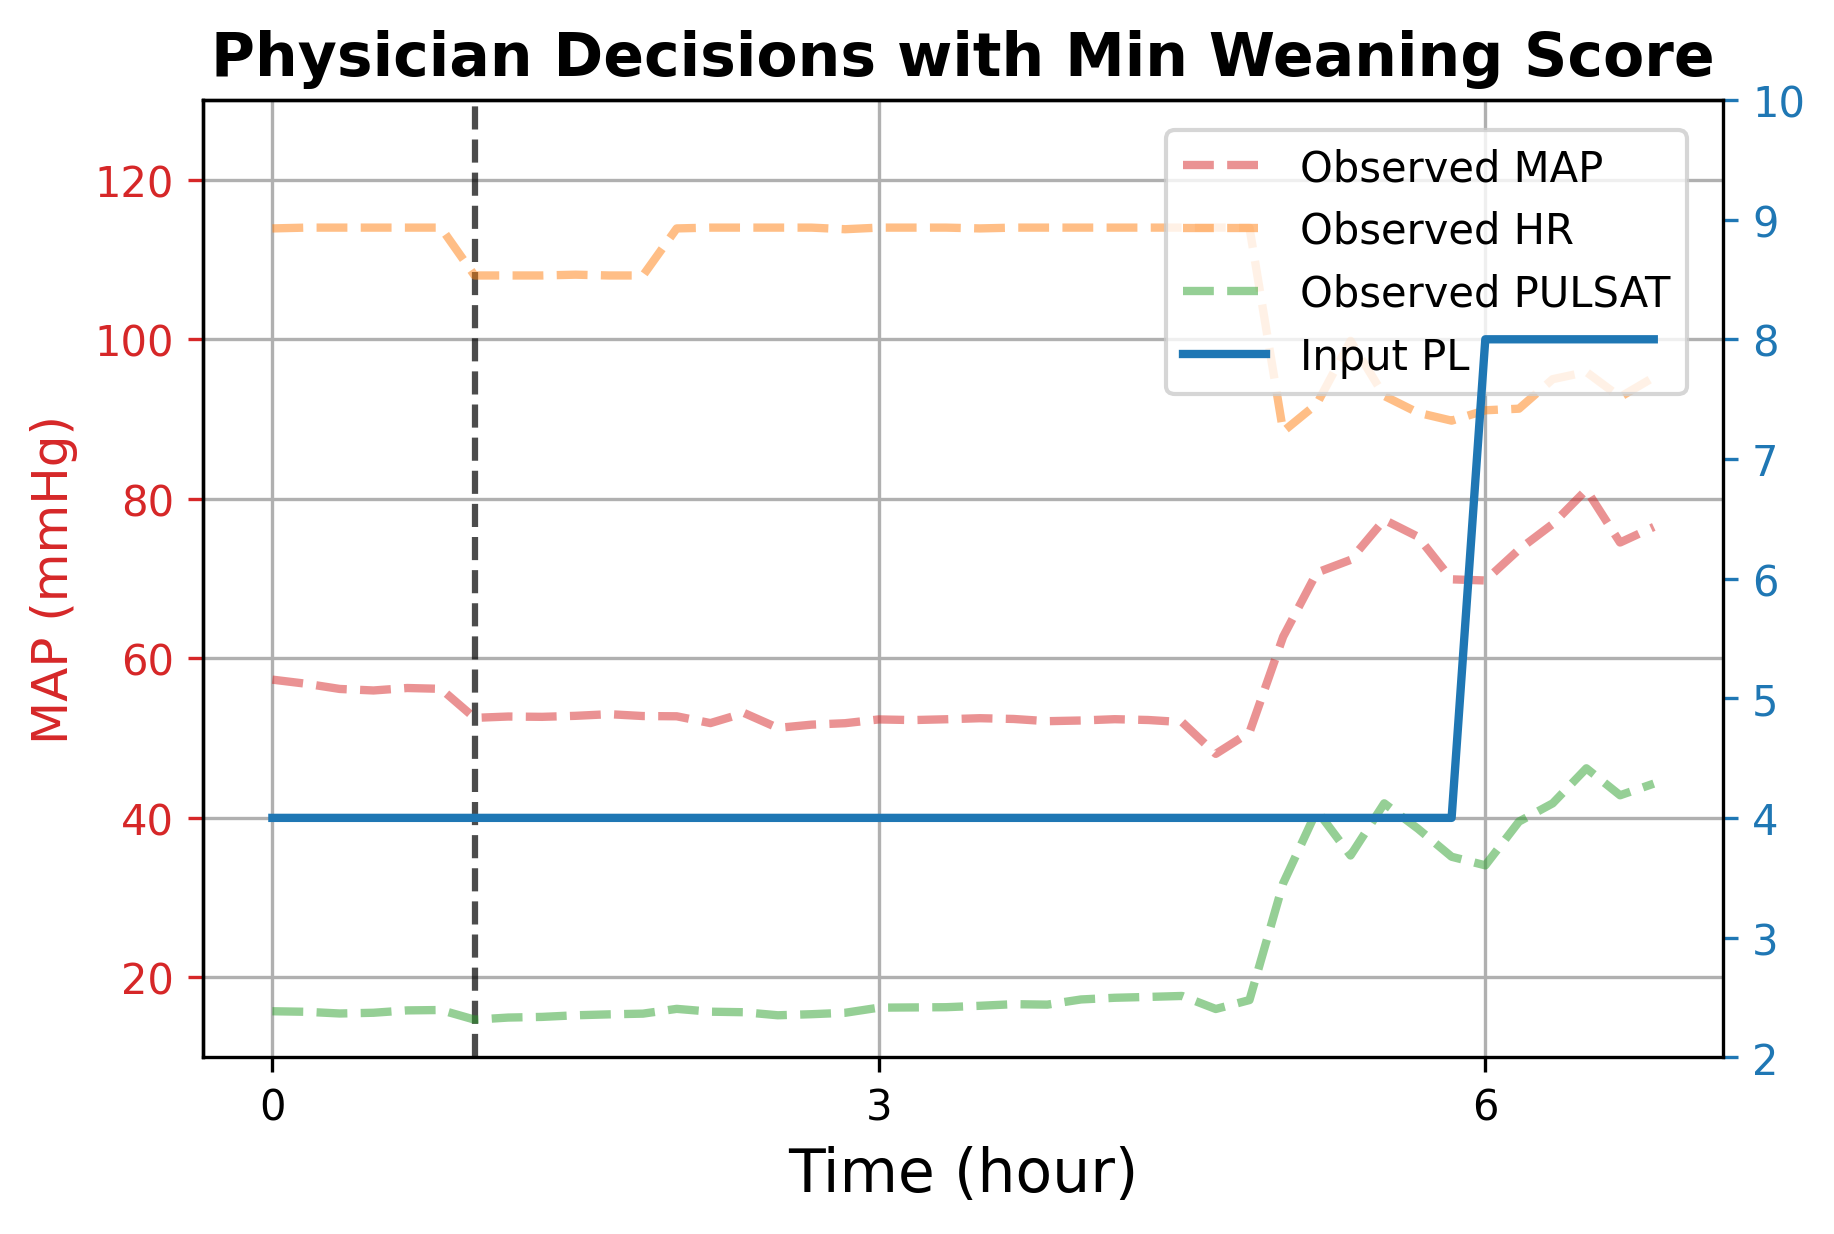

Weaning score in this episode -1.0


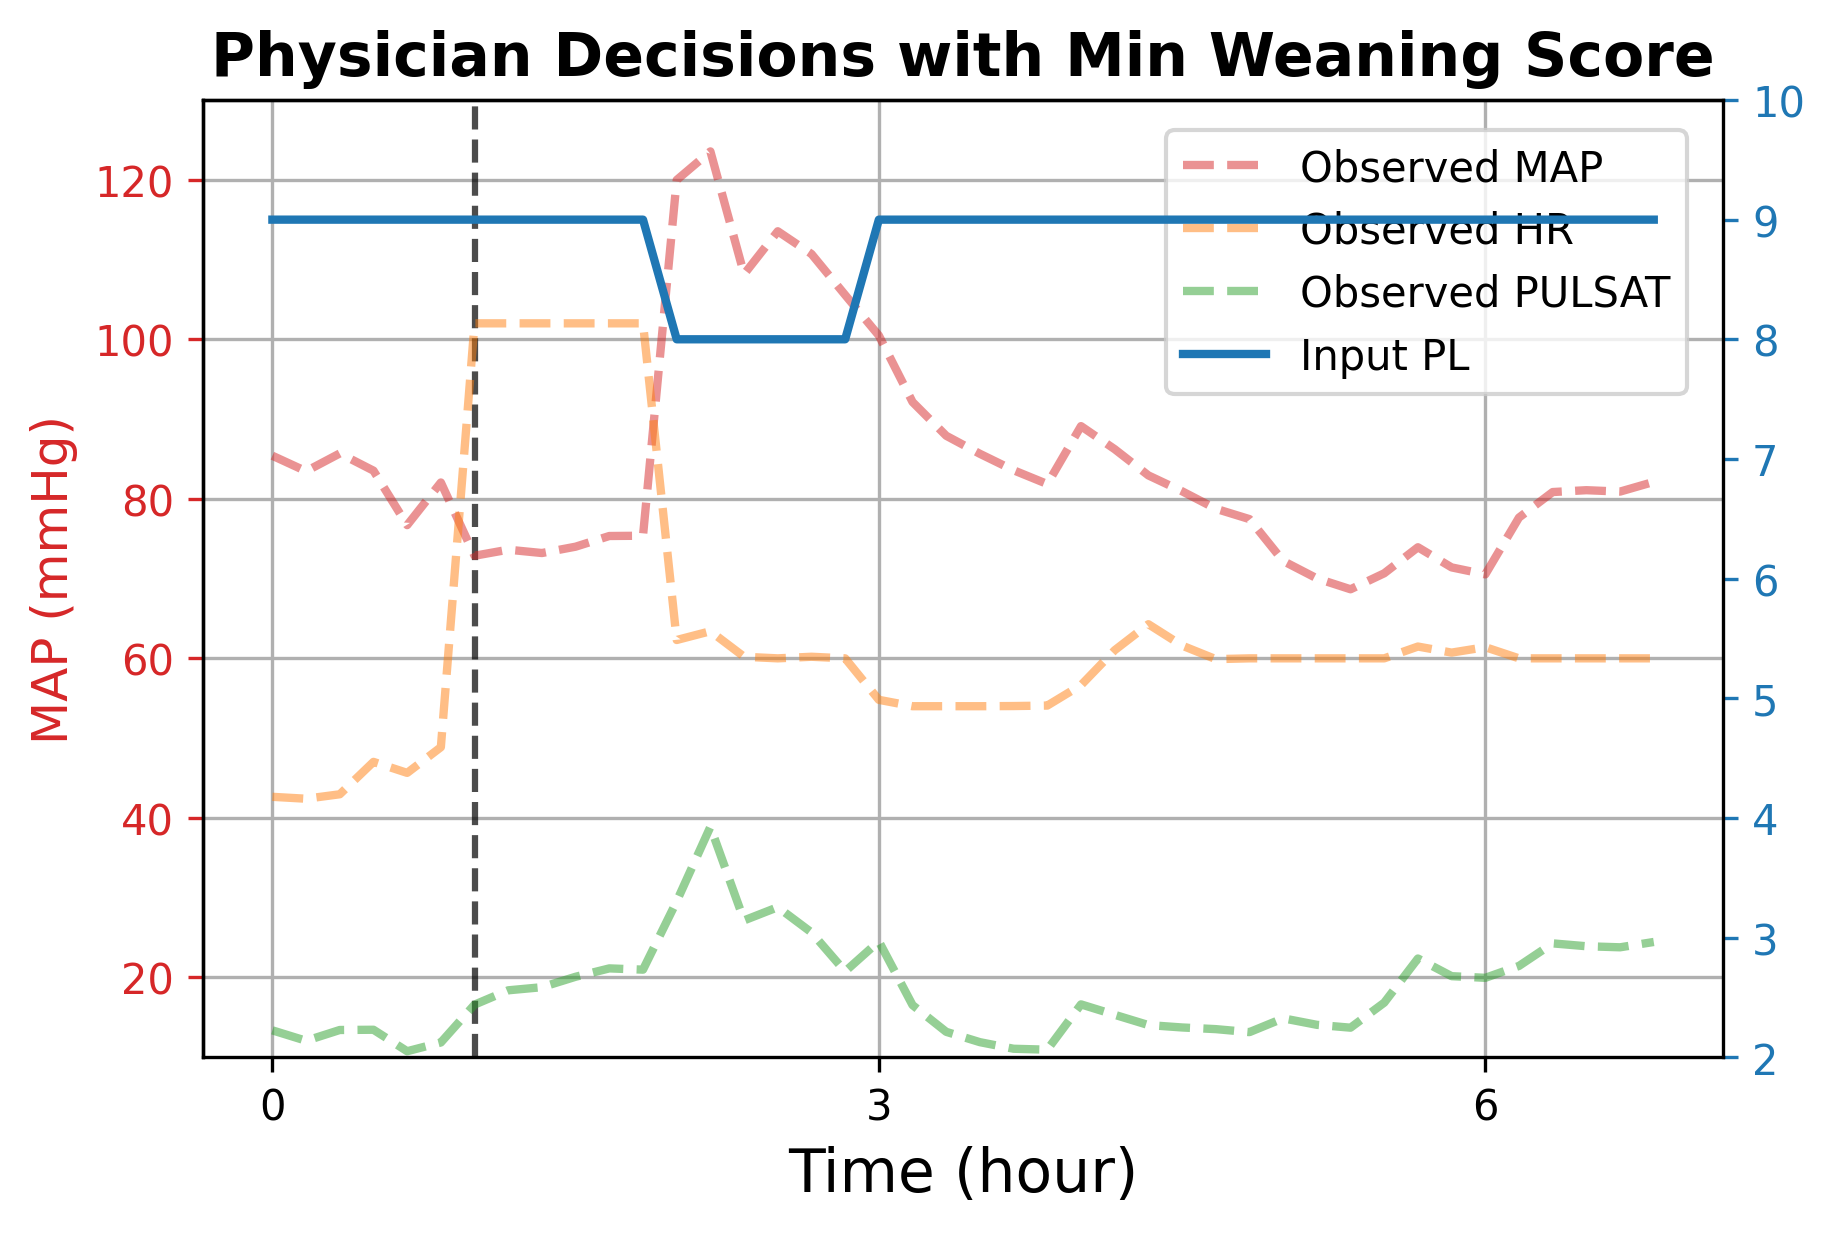

Weaning score in this episode -1.0
Mean normalized reward per episode: 0.3712
Mean ACP per episode: 1.7863
Mean Aggregate AIR per episode: 0.4275
Mean Super Metric per episode: 0.0000
Mean Weaning Score per episode: 0.0764
percentage of episodes with acp > 2.0 29.166666666666668 | max ACP in an episode 21.0 | min ACP in an episode 0.0
percentage of episodes with ws <= 0 12.634408602150538 | max Weaning Score in an episode 2.0 | min Weaning Score in an episode -1.0


In [9]:
#just 100 eval episodes for reward

all_normalized_rewards = []
total_map_air_sum          = 0
total_hr_air_sum           = 0
total_pulsatility_air_sum  = 0
total_aggregate_air_sum    = 0
total_super_sum            = 0
avg_acp = 0
wean_score_sum = 0
num_acp = 0.0
num_ws = 0.0
acp_list = []
ws_list = []
plotted = 0
for episode_idx in range(eval_episodes):
    episode_states = []
    episode_actions = []
    total_normalized_reward = 0
    for state_idx in range(episode_len):
        state = torch.tensor(sliced_data_episodic[episode_idx, state_idx, :6, col].transpose(), dtype=torch.float32).reshape(6,12)
        next_state = torch.tensor(sliced_data_episodic[episode_idx, state_idx, 6:, col].transpose(), dtype=torch.float32).reshape(6,12)
        action = np.array(np.bincount(np.rint(sliced_data_episodic[episode_idx, state_idx, 6:, -1]).astype(int)).argmax())

        reward = compute_reward_smooth(next_state)
        norm_reward = (reward + 1.7018) / 2.6621
        total_normalized_reward += np.clip(norm_reward, -2.0, None) 

        episode_states.append(state.numpy())
        episode_actions.append(action)
    
    episode_states_np = np.asarray(episode_states)
    all_normalized_rewards.append(total_normalized_reward)
    acp = compute_acp_cost(episode_actions, episode_states_np)
    acp_list.append(acp)
    avg_acp += acp
    # total_map_air_sum          += compute_map_physician_air(episode_states, episode_actions)
    # total_hr_air_sum           += compute_hr_physician_air( episode_states,episode_actions)
    # total_pulsatility_air_sum  += compute_pulsatility_physician_air( episode_states, episode_actions)
    total_aggregate_air_sum    += aggregate_air_physician(episode_states_np, episode_actions)
    ws = weaning_score_physician(episode_states_np, episode_actions)
    ws_list.append(ws)
    wean_score_sum             += ws
    if acp >= 3.0: 
        num_acp +=1
        if num_acp == 1:
            episode_states.append(next_state.numpy())
            plot_policy(np.array(episode_states), np.array(episode_actions), "Physician Decisions", legend=True)
            print('ACP in this episode', acp)
        if acp == 21:
            episode_states.append(next_state.numpy())
            plot_policy(np.array(episode_states), np.array(episode_actions), "Physician Decisions with Max ACP",legend=True)
            print('ACP in this episode', acp)
        # if acp == 3:
        #     episode_states.append(next_state.numpy())
        #     plot_policy(np.array(episode_states), np.array(episode_actions), "Physician Decisions with ACP=2",legend=True)
        #     print('ACP in this episode', acp)
    if ws < 0.0:
        num_ws +=1
        if num_ws == 1:
            episode_states.append(next_state.numpy())
            plot_policy(np.array(episode_states), np.array(episode_actions), "Physician Decisions with Weaning Score 0",legend=True)
            print('Weaning score in this episode', ws)
        if ws == -1.0:
            episode_states.append(next_state.numpy())
            plot_policy(np.array(episode_states), np.array(episode_actions), "Physician Decisions with Min Weaning Score",legend=True)
            print('Weaning score in this episode', ws)
    
    if (ws == 2.0) and (plotted== 0):
        plotted = 1
        episode_states.append(next_state.numpy())
        plot_policy(np.array(episode_states), np.array(episode_actions), "Physician Decisions with Max Weaning Score",legend=True)
        print('Weaning score in this episode', ws)
        
    # total_super_sum            += super_metric(episode_states, episode_actions)
mean_normalized_reward = np.mean(all_normalized_rewards)
print(f"Mean normalized reward per episode: {mean_normalized_reward:.4f}")
avg_acp /= eval_episodes
print(f"Mean ACP per episode: {avg_acp:.4f}")

total_aggregate_air_sum /= eval_episodes
print(f"Mean Aggregate AIR per episode: {total_aggregate_air_sum:.4f}")
total_super_sum /= eval_episodes
print(f"Mean Super Metric per episode: {total_super_sum:.4f}")
total_weaning_score = wean_score_sum / eval_episodes
print(f"Mean Weaning Score per episode: {total_weaning_score:.4f}")
print('percentage of episodes with acp > 2.0', num_acp/eval_episodes*100, "| max ACP in an episode", np.max(acp_list), "| min ACP in an episode", np.min(acp_list))
print('percentage of episodes with ws <= 0', num_ws/eval_episodes*100, "| max Weaning Score in an episode", np.max(ws_list), "| min Weaning Score in an episode", np.min(ws_list))

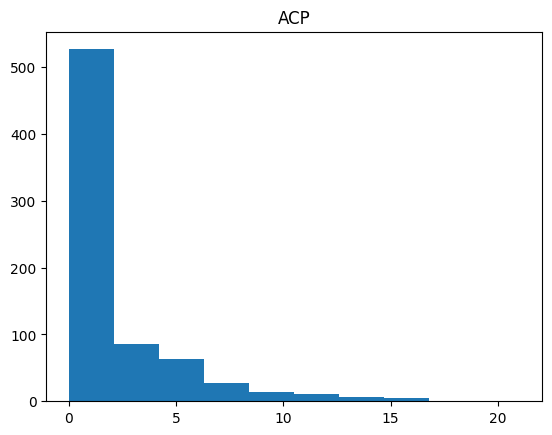

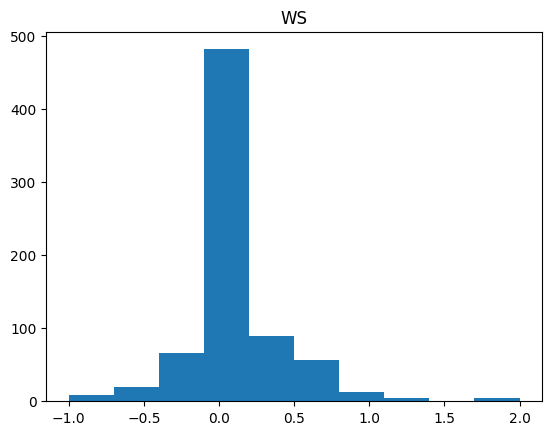

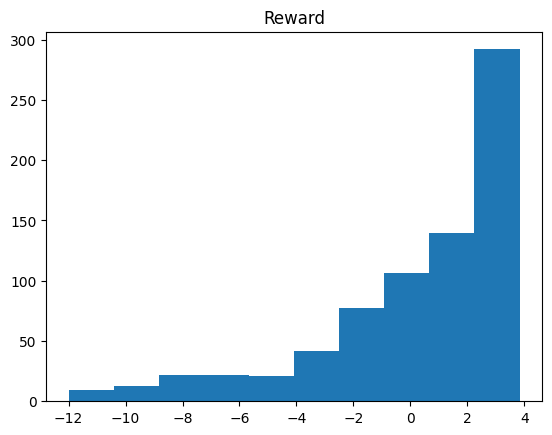

In [13]:
plt.hist(acp_list)
plt.title('ACP')
plt.show()
plt.hist(ws_list)
plt.title('WS')
plt.show()
plt.hist(all_normalized_rewards)
plt.title('Reward')
plt.show()

In [30]:
np.array(episode_actions)

array([7, 7, 7, 7, 7, 7])

## DT-based Metrics

In [18]:

eval_env = AbiomedRLEnvFactory.create_env(
									model_name="10min_1hr_all_data",
									model_path=None,
									data_path=None,
									max_steps=6,
									action_space_type="continuous",
									reward_type="smooth",
									normalize_rewards=True,
									seed=42,
									device = f"cuda:1" if torch.cuda.is_available() else "cpu",
									)

avg_reward = 0.0
avg_acp = 0.0

# ---- aggregated metrics over episodes ----
total_map_air_sum = 0.0
total_hr_air_sum = 0.0
total_pulsatility_air_sum = 0.0
total_aggregate_air_sum = 0.0
total_unstable_percentage_sum = 0.0
total_super_sum = 0.0
wean_score_sum = 0.0

num_acp = 0.0
num_ws = 0.0
acp_list = []
ws_list = []
plotted = 0
for k in range(eval_episodes):
    ep_states = []           # store normalized states per step (like in _evaluate)
    actions = []
    for t in range(episode_len):
        action = sliced_next_state_episodic[k, t, :, -1]
        action1 = np.array(np.bincount(np.rint(action).astype(int)).argmax())
        state = sliced_state_episodic[k, t, :, col].transpose()
        #normalize the state
        state = (torch.tensor(state) - eval_env.world_model.mean[col]) / eval_env.world_model.std[col]

        with torch.no_grad():
            next_state = eval_env.world_model.step(torch.tensor(state).unsqueeze(0), int(action1)).squeeze(0)
        
        reward = eval_env._compute_reward(next_state)
        avg_reward += reward.item()  # accumulate raw reward

        ep_states.append(state.numpy())   # store the *current* obs like _evaluate
        actions.append(int(action1))  # store the *current* action like _evaluate

    
    ep_states_np = np.asarray(ep_states, dtype=np.float32) #normalized
    action_np = np.asarray(actions, dtype=np.int32) #unnormalized


    wm = getattr(eval_env, 'world_model', None)
    if wm is None:
        wm = eval_env.world_model  # fallback to global `env` if that's how you access it

    # AIR metrics
    # total_map_air_sum          += compute_map_physician_air(wm, ep_states_np, eval_env.episode_actions)
    # total_hr_air_sum           += compute_hr_physician_air(wm, ep_states_np, eval_env.episode_actions)
    # total_pulsatility_air_sum  += compute_pulsatility_physician_air(wm, ep_states_np, eval_env.episode_actions)
    acp = compute_acp_cost_model(wm,action_np,ep_states_np)
    acp_list.append(acp)
    avg_acp += acp
    total_aggregate_air_sum    += aggregate_air_model(wm, ep_states_np, action_np)
    total_super_sum            += super_metric(wm, ep_states_np, action_np)
    ws = weaning_score_model(wm, ep_states_np, action_np)
    ws_list.append(ws)
    wean_score_sum             += ws
    # if acp >= 3.0: 
    #     num_acp +=1
    #     if num_acp == 1:
    #         episode_states.append(next_state.numpy())
    #         plot_policy(np.array(episode_states), np.array(episode_actions), "Physician Decisions", legend=True)
    #         print('ACP in this episode', acp)
    #     if acp == 21:
    #         episode_states.append(next_state.numpy())
    #         plot_policy(np.array(episode_states), np.array(episode_actions), "Physician Decisions with Max ACP",legend=True)
    #         print('ACP in this episode', acp)
        # if acp == 3:
        #     episode_states.append(next_state.numpy())
        #     plot_policy(np.array(episode_states), np.array(episode_actions), "Physician Decisions with ACP=2",legend=True)
        #     print('ACP in this episode', acp)
    # if ws <= 0.0:
    #     num_ws +=1
    #     if num_ws == 1:
    #         episode_states.append(next_state.numpy())
    #         plot_policy(np.array(episode_states), np.array(episode_actions), "Physician Decisions with Weaning Score 0",legend=True)
    #         print('Weaning score in this episode', ws)
    #     if ws == -1.0:
    #         episode_states.append(next_state.numpy())
    #         plot_policy(np.array(episode_states), np.array(episode_actions), "Physician Decisions with Min Weaning Score",legend=True)
    #         print('Weaning score in this episode', ws)
    
    # if (ws == 2.0) and (plotted== 0):
    #     plotted = 1
    #     episode_states.append(next_state.numpy())
    #     plot_policy(np.array(episode_states), np.array(episode_actions), "Physician Decisions with Max Weaning Score",legend=True)
    #     print('Weaning score in this episode', ws)
        
    # total_unstable_percentage_sum += unstable_percentage(wm, ep_states_np)   

# ---- episode averages ----
avg_reward /= eval_episodes
acp_mean = avg_acp / eval_episodes

map_air_mean          = total_map_air_sum / eval_episodes
hr_air_mean           = total_hr_air_sum / eval_episodes
puls_air_mean         = total_pulsatility_air_sum / eval_episodes
aggregate_air_mean    = total_aggregate_air_sum / eval_episodes
unstable_hours_mean   = total_unstable_percentage_sum / eval_episodes
weaning_score_mean    = wean_score_sum / eval_episodes
super_mean            = total_super_sum / eval_episodes

print("---------------------------------------")
print(f"Evaluation over {eval_episodes} episodes: "
        f"Return {avg_reward:.3f}")
print(f"ACP {acp_mean:.4f}")
# print(f"MAP AIR/ep: {map_air_mean:.5f} | HR AIR/ep: {hr_air_mean:.5f} "
#         f"| Pulsatility AIR/ep: {puls_air_mean:.5f}")
print(f"Aggregate AIR/ep: {aggregate_air_mean:.5f}")
print(f"Unstable hours (%): {unstable_hours_mean}")
print(f"Weaning score: {weaning_score_mean}")
print(f"Super metric: {super_mean:.5f}")
print("---------------------------------------")

<module 'noisy_mujoco.abiomed_env.config' from '/home/ubuntu/noisy_mujoco/abiomed_env/config.py'>
time series transformer device cuda:1
Using device: cuda:1
Model loaded from /abiomed/downsampled/models/10min_1hr_all_data_model.pth
loaded datasets with length 
 train:  12051 
 val:  1938 
 test:  3876
Data loaded from /abiomed/downsampled/10min_1hr_all_data.pkl
Continuous action space. Min action: -2.2312597235306466, Max action: 1.8085589693336617
Continuous action space. Min action: -2.2312597235306466, Max action: 1.8085589693336617


/tmp/ipykernel_1672724/2889030895.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = eval_env.world_model.step(torch.tensor(state).unsqueeze(0), int(action1)).squeeze(0)


---------------------------------------
Evaluation over 744 episodes: Return 0.614
ACP 1.7863
Aggregate AIR/ep: 0.42751
Unstable hours (%): 0.0
Weaning score: 0.07641129032258068
Super metric: 1.43414
---------------------------------------


# Synthetic Dataset

In [2]:
SYN_DATA_PATH = "/abiomed/offline_datasets/SAC_exp_5000eps_stochastic_noise0.80_scale0.20.npz"
eval_env = AbiomedRLEnvFactory.create_env(
									model_name="10min_1hr_all_data",
									model_path=None,
									data_path=None,
									max_steps=6,
									action_space_type="continuous",
									reward_type="smooth",
									normalize_rewards=True,
									seed=42,
									device = f"cuda:1" if torch.cuda.is_available() else "cpu",
									)

dataset = np.load(SYN_DATA_PATH)
dataset = {k: dataset[k] for k in dataset.files}

dataset['observations'] =  dataset['observations'][::4]
dataset['next_observations'] = dataset['next_observations'][::4]
dataset['actions'] = dataset['actions'][::4]
dataset['rewards'] = dataset['rewards'][::4]



# dataset['actions'] = np.asarray(eval_env.world_model.normalize_pl(torch.Tensor(dataset['actions']))).reshape(-1,1)

<module 'noisy_mujoco.abiomed_env.config' from '/home/ubuntu/noisy_mujoco/abiomed_env/config.py'>
time series transformer device cuda:1
Using device: cuda:1


/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/ubuntu/noisy_mujoco/abiomed_env/model.py:406: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allow

Model loaded from /abiomed/downsampled/models/10min_1hr_all_data_model.pth
loaded datasets with length 
 train:  12051 
 val:  1938 
 test:  3876
Data loaded from /abiomed/downsampled/10min_1hr_all_data.pkl
Continuous action space. Min action: -2.2312597235306466, Max action: 1.8085589693336617
Continuous action space. Min action: -2.2312597235306466, Max action: 1.8085589693336617


In [3]:
next_states = dataset['next_observations'].copy().reshape(-1,6,6,12)
states = dataset['observations'].copy().reshape(-1,6,6,12)
action_all = dataset['actions'].copy().reshape(-1,6,1,1)
col = [0,1,2,3,4,5,6,7,8,9,10,12]
eval_episodes = states.shape[0]
episode_len = states.shape[1]
avg_reward = 0.0
avg_acp = 0.0


In [3]:

# ---- aggregated metrics over episodes ----
total_map_air_sum = 0.0
total_hr_air_sum = 0.0
total_pulsatility_air_sum = 0.0
total_aggregate_air_sum = 0.0
total_unstable_percentage_sum = 0.0
total_super_sum = 0.0
wean_score_sum = 0.0

for k in range(eval_episodes):
    ep_states = []           # store normalized states per step (like in _evaluate)
    actions = []
    for t in range(episode_len):
        action1 = action_all[k, t, :, -1]
        # action1 = np.array(np.bincount(action.astype(int)).argmax())
        state = states[k, t, :, :]
        #normalize the state
        # state = (torch.tensor(state) - eval_env.world_model.mean[col]) / eval_env.world_model.std[col]

        with torch.no_grad():
            next_state = eval_env.world_model.step(torch.tensor(state).unsqueeze(0), int(action1)).squeeze(0)
        
        reward = eval_env._compute_reward(next_state)
        avg_reward += reward.item()  # accumulate raw reward

        ep_states.append(state)   # store the *current* obs like _evaluate
        actions.append(int(action1))  # store the *current* action like _evaluate

    
    ep_states_np = np.asarray(ep_states, dtype=np.float32) #normalized
    action_np = np.asarray(actions, dtype=np.int32) #unnormalized


    wm = getattr(eval_env, 'world_model', None)
    if wm is None:
        wm = eval_env.world_model  # fallback to global `env` if that's how you access it

    # AIR metrics
    # total_map_air_sum          += compute_map_physician_air(wm, ep_states_np, eval_env.episode_actions)
    # total_hr_air_sum           += compute_hr_physician_air(wm, ep_states_np, eval_env.episode_actions)
    # total_pulsatility_air_sum  += compute_pulsatility_physician_air(wm, ep_states_np, eval_env.episode_actions)
    avg_acp += compute_acp_cost_model(wm,action_np,ep_states_np)
    total_aggregate_air_sum    += aggregate_air_model(wm, ep_states_np, action_np)
    total_super_sum            += super_metric(wm, ep_states_np, action_np)
    wean_score_sum             += weaning_score_model(wm, ep_states_np, action_np)
    # total_unstable_percentage_sum += unstable_percentage(wm, ep_states_np)   

# ---- episode averages ----
avg_reward /= eval_episodes
acp_mean = avg_acp / eval_episodes

map_air_mean          = total_map_air_sum / eval_episodes
hr_air_mean           = total_hr_air_sum / eval_episodes
puls_air_mean         = total_pulsatility_air_sum / eval_episodes
aggregate_air_mean    = total_aggregate_air_sum / eval_episodes
unstable_hours_mean   = total_unstable_percentage_sum / eval_episodes
weaning_score_mean    = wean_score_sum / eval_episodes
super_mean            = total_super_sum / eval_episodes

print("---------------------------------------")
print(f"Evaluation over {eval_episodes} episodes: "
        f"Return {avg_reward:.3f}")
print(f"ACP {acp_mean:.4f}")
# print(f"MAP AIR/ep: {map_air_mean:.5f} | HR AIR/ep: {hr_air_mean:.5f} "
#         f"| Pulsatility AIR/ep: {puls_air_mean:.5f}")
print(f"Aggregate AIR/ep: {aggregate_air_mean:.5f}")
print(f"Unstable hours (%): {unstable_hours_mean}")
print(f"Weaning score: {weaning_score_mean}")
print(f"Super metric: {super_mean:.5f}")
print("---------------------------------------")

---------------------------------------
Evaluation over 1250 episodes: Return 1.448
ACP 9.6240
Aggregate AIR/ep: 0.46651
Unstable hours (%): 0.0
Weaning score: -0.22942666666666658
Super metric: 3.31200
---------------------------------------


In [4]:
#just 100 eval episodes for reward
unnorm_state = eval_env.world_model.unnorm_output(torch.tensor(dataset['observations'].reshape(-1,6,12), dtype=torch.float32)).reshape(-1,6,6,12)
unnorm_next_state = eval_env.world_model.unnorm_output(torch.tensor(dataset['next_observations'].reshape(-1,6,12), dtype=torch.float32)).reshape(-1,6,6,12)



all_normalized_rewards = []
total_map_air_sum          = 0
total_hr_air_sum           = 0
total_pulsatility_air_sum  = 0
total_aggregate_air_sum    = 0
total_super_sum            = 0
avg_acp = 0
wean_score_sum = 0

for episode_idx in range(eval_episodes):
    episode_states = []
    episode_actions = []
    total_normalized_reward = 0
    for state_idx in range(episode_len):
        
        state = unnorm_state[episode_idx, state_idx, :, :]
        next_state = unnorm_next_state[episode_idx, state_idx, :, :]
        action = action_all[episode_idx, state_idx, :, :].reshape(-1)

        reward = compute_reward_smooth(next_state)
        norm_reward = (reward + 1.7018) / 2.6621
        total_normalized_reward += np.clip(norm_reward, -2.0, None) 

        episode_states.append(state.numpy())
        episode_actions.append(action)
    episode_states_np = np.asarray(episode_states)
    all_normalized_rewards.append(total_normalized_reward)
    avg_acp += compute_acp_cost(np.asarray(episode_actions).reshape(-1), episode_states_np)
    # total_map_air_sum          += compute_map_physician_air(episode_states, episode_actions)
    # total_hr_air_sum           += compute_hr_physician_air( episode_states,episode_actions)
    # total_pulsatility_air_sum  += compute_pulsatility_physician_air( episode_states, episode_actions)
    total_aggregate_air_sum    += aggregate_air_physician(episode_states_np, np.asarray(episode_actions).reshape(-1))
    wean_score_sum             += weaning_score_physician(episode_states_np, np.asarray(episode_actions).reshape(-1))

    # total_super_sum            += super_metric(episode_states, episode_actions)
mean_normalized_reward = np.mean(all_normalized_rewards)
print(f"Mean normalized reward per episode: {mean_normalized_reward:.4f}")
avg_acp /= eval_episodes
print(f"Mean ACP per episode: {avg_acp:.4f}")

total_aggregate_air_sum /= eval_episodes
print(f"Mean Aggregate AIR per episode: {total_aggregate_air_sum:.4f}")
total_super_sum /= eval_episodes
print(f"Mean Super Metric per episode: {total_super_sum:.4f}")
total_weaning_score = wean_score_sum / eval_episodes
print(f"Mean Weaning Score per episode: {total_weaning_score:.4f}")

Mean normalized reward per episode: 1.4364
Mean ACP per episode: 9.6240
Mean Aggregate AIR per episode: 0.4665
Mean Super Metric per episode: 0.0000
Mean Weaning Score per episode: -0.1473
